## Imports

In [28]:
!pip install Unidecode
!pip install imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import pandas as pd
import numpy as np
from tqdm import tqdm
import sqlalchemy
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import unidecode
import pickle
import umap
import re
import string
from string import punctuation
from gensim.models import Word2Vec
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict,\
                         ShuffleSplit,StratifiedShuffleSplit, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, average_precision_score
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

## Funções

In [29]:
def grava(obj, path, filename):
    with open(path + filename, 'wb') as pkl_file:
      pickle.dump(obj, pkl_file)

def abre(path, filename):
    with open(path + filename, 'rb') as pkl_file:
      obj = pickle.load(pkl_file)
      return obj

def pre_processing_pln(df):
    
    lemmatizer=WordNetLemmatizer()
    stemmer = nltk.stem.RSLPStemmer()

    df['xprod'] = df['xprod'].apply(lambda x: ' '.join([ lemmatizer.lemmatize(item) for item in x.split() ] ))
    df['xprod'] = df['xprod'].apply(lambda x: ' '.join([ stemmer.stem(item) for item in x.split()] ))

    return df


def calc_preco(df, grupos, descricoes):

  groupos_id = []
  group_names = []
  media = []
  mediana = []
  media_saneada = []
  precos_max = []
  precos_min = []
    
  for i, grupo in enumerate(grupos):
    df_grupo = df[df['classe'] == grupo]

    #S = E – M sobrepreço estimado - referencial mercado
    media.append(round(df_grupo['vuncom'].mean(),3))
    mediana.append(round(df_grupo['vuncom'].median(),3))
    nova_media, preco_max, preco_min = calc_media_saneada(df_grupo)
    
    media_saneada.append(nova_media)
    precos_max.append(preco_max)
    precos_min.append(preco_min)

    descricao = descricoes[i]
    group_names.append(descricao)
    
    groupos_id.append(i+1)

  df_precos = pd.DataFrame(zip(groupos_id, group_names, media, mediana, precos_max, precos_min, media_saneada),\
                            columns=["id","Classe", "Media", "Mediana", "Max", "Min", "Media Saneada"])

  df_precos = df_precos.round(2)
  df_precos['Media'] = df_precos['Media'].astype(str).str.replace('.',",")  
  df_precos['Mediana'] = df_precos['Mediana'].astype(str).str.replace('.',",")  
  df_precos['Max'] = df_precos['Max'].astype(str).str.replace('.',",")  
  df_precos['Min'] = df_precos['Min'].astype(str).str.replace('.',",")  
  df_precos['Media Saneada'] = df_precos['Media Saneada'].astype(str).str.replace('.',",")

  df_precos.set_index('id', inplace=True)
  #load precos filename
  df_precos.to_csv('precos_produtos.csv', encoding='utf-8-sig')
	

def calc_media_saneada(df):
  '''
  '''
  preco = df['vuncom']
  preco_max = max(preco)
  preco_min = min(preco)
  preco_mean = preco.mean()
  LS = preco_mean + preco.std()
  LI = preco_mean - preco.std()		
  CV = abs(preco.std() / preco_mean)

  if CV > 0.25:
    precos = preco[preco.between(LI, LS)]
    return (precos.mean(), preco_max, preco_min)
  else:
    return (preco_mean, preco_max, preco_min)


def reindex_grupos(df):
  classes = df['classe'].unique().tolist()
  classes.sort()
  reindex={}
  for i, classe in enumerate(classes):
    reindex[classe] = i+1
  df['classe'] = df['classe'].map(reindex)
  
  return df

## Limpando descricoes

In [30]:
lista_ncms = set(['02012090', '02013000', '02022090', '02071200', '02071300', '02071400', '02102000', '04022110', \
            '04031000', '04039000', '07061000', '07061000', '09012100', '10062010', '10063011', '10063021', '11010010', '11022000', \
            '11041200', '11041900', '11042300', '11062000', '11081200', '11081400', '15079011', '15091000', '15171000', '17019900', \
            '17031000', '17039000', '18061000', '18069000', '19021900', '19053100', '19059020', '20060000', '20083000', '20089900', \
            '20099000', '21042000', '21069090', '22011000', '25010020', '25221000', '25222000', '25223000', '25232910', '27101259', \
            '27101921', '27111910', '28044000', '28111990', '28112990', '28289011', '28539090', '30012090', '30021229', '30021590', \
            '30032029', '30032099', '30039071', '30041019', '30042029', '30042099', '30049024', '30049037', '30049059', '30049069', \
            '30049099', '30059090', '30051090', '34022000', '36050000', '39241000', '40111000', '40112090', '40151100', '40151900', \
            '48181000', '48183000', '48189090','84151011', '84212300', '96039000']) 

lista_lt = ['li','lr','lit','litro', 'litros', 'ltr','l','lt', 'lts', 'ltrs']
lista_kg = ['kg','quilo','km','kg1', 'kg3', 'kg2']
lista_und = ['und','un','un0001','unid','un1','1', 'uni','un.','unid.','unidad','ud']
lista_pct = ['pct', 'pc','pt','pc1','pact','pacote','pa','pcs']
lista_cx = ['cx','caixa','cx20','cx12','cx48','cxs','cxa','cx24']
lista_frd = ['fdo','fardo','frd','fd','fd12','fr','far','fd27','fdo']
lista_saco = ['sc']
unidades = set(lista_lt+lista_kg+lista_und+lista_pct+lista_cx+lista_frd+lista_saco)

pt_stopwords = set(nltk.corpus.stopwords.words("portuguese"))
punct = set(list(punctuation))
stopwords = set(['gtin','ok','marca','in', 'natura', 'nacional','embalagem','vitamassa','tipo','hort','qtd.', '1ª',\
                 'qualidade', 'bom', 'todo','cs','dona', 'clara','rei','ouro','lua', 'azul','belo','grao','marata',\
                 'polo', 'iii','bem','primeira','endereco','sa'])
pt_stopwords.update(punct)
pt_stopwords.update(stopwords)

In [31]:
df_produto = pd.read_csv('produtos.csv')
df_produto['definicao'] = np.NaN
df_produto['ncm'] = df_produto.ncm.astype(str)
df_produto['ncm'] = df_produto['ncm'].apply(lambda x: ''.join(['0',x]) if len(x) == 7 else x)
#df_produto = df_produto[df_produto['ncm'].isin(lista_ncms)]
#salva xprod original
df_produto['Produto'] = df_produto['xprod']
df_produto['ucom'] = df_produto['ucom'].replace('^\s*$|^$', 'und', regex=True)

df_produto.loc[df_produto.ucom.isin(lista_lt), 'ucom'] = 'lt'
df_produto.loc[df_produto.ucom.isin(lista_kg), 'ucom'] = 'kg'
df_produto.loc[df_produto.ucom.isin(lista_und), 'ucom'] = 'und'
df_produto.loc[df_produto.ucom.isin(lista_pct), 'ucom'] = 'pct'
df_produto.loc[df_produto.ucom.isin(lista_cx), 'ucom'] = 'cx'
df_produto.loc[df_produto.ucom.isin(lista_frd), 'ucom'] = 'frd'
df_produto.loc[df_produto.ucom.isin(lista_saco), 'ucom'] = 'sc'
df_produto.loc[~df_produto.ucom.isin(unidades), 'ucom'] = 'und' 
unidades.update(set(['g','gr', 'ml','cm']))

In [32]:
#df_produto.loc[(df_produto.xprod.str.contains('diesel'))]['ucom'].unique().tolist()
# ['lt', 'und', 'frd', 'pct', 'kg', 'cx']
#df_produto.loc[(df_produto.xprod.str.contains('diesel'))& (df_produto.ucom.isin(['cx']))]['xprod'][:20].unique().tolist()

['oleo lubrificante para motor a diesel 5w30 sintetico lubrax',
 'oleo lubrificante motor diesel 10w40 lubrax',
 'oleo para motor a diesel sintetico',
 'oleo ipi brutus sint 5w30 c2c3 24x1 diesel']

In [33]:
def remove_numeros_inicio(descr):
  while ( (len(descr) > 1) and (descr.split()[0].isdigit()) ):
    descr = ' '.join( descr.split()[1:] )
  return descr

# limpa sentencas retirando stopwords, pontuacao e deixa minusculo.
df_produto.loc[:, 'xprod'] = [ ' '.join([word.lower() for word in descr.split() if word.lower() not in pt_stopwords]) for descr in df_produto['xprod'].astype(str)]
# insere espaco apos / . e -, pra no final nao ficar palavras assim: csolucao, ptexto defliq (originais eram c/solucao, p-texto, def.liqu) 
df_produto.loc[:, 'xprod'] = df_produto['xprod'].apply(lambda descr: re.sub(r'/|-',r' ',descr))
# retira . entre palavras tipo det.liqu 
df_produto.loc[:, 'xprod'] = df_produto['xprod'].apply(lambda x: ' '.join( [re.sub(r'\.',r' ', word) if '.' in word and not any(char.isdigit() for char in word) else word for word in x.split()] ) )
# retira pontuacao (com exceção de virgula e ponto dos numeros):
df_produto.loc[:, 'xprod'] = df_produto['xprod'].apply(lambda x: ''.join(re.findall('\d{1}\.\d{1}|\d{1}\,\d{1}|\w|\s', x)))
# insere espaco apos numero e letra (separa unidades de medida:) ex.: 500ml vs 100ml vs 500mg
df_produto.loc[:, 'xprod'] = df_produto['xprod'].apply(lambda x: re.sub(r'(\d+)([A-Za-z])',r'\1 \2',x))
# insere espaco apos letra e numero ex.:c100 pc50
df_produto.loc[:, 'xprod'] = df_produto['xprod'].apply(lambda x: re.sub(r'([A-Za-z]{1})(\d+)',r'\1 \2',x))
# insere espaco se unidade esta colada em outro medida ex.: 5litros 
df_produto.loc[:, 'xprod'] = df_produto['xprod'].apply(lambda x: re.sub(r'(\d+)(l|lt|litro|litros|li|kg|ml|mg|cm|g|gr|kga)',r'\1 \2',x))
# apaga caracteres pequenos se n estiver nas condições
df_produto.loc[:, 'xprod'] = df_produto['xprod'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 1 or word == 'c' or word == 's' or word in unidades or word.isdigit()]))
# retira espacos duplicados
df_produto.loc[:, 'xprod'] = df_produto['xprod'].apply(lambda x: re.sub(r' +',r' ', x))
# retira espaco no inicio da frase
df_produto.loc[:, 'xprod'] = df_produto['xprod'].apply(lambda x: x.strip())
# retira acentos:
df_produto.loc[:, 'xprod'] = df_produto['xprod'].apply(lambda x: unidecode.unidecode(x))
# remove zeros a esquerda de numeros (02 litros, 05, etc.) caso não tenha , e . 
df_produto.loc[:, 'xprod'] = df_produto['xprod'].apply(lambda x: ' '.join( [word.lstrip('0') for word in x.split() if ',' not in word or '.' not in word] ) )
# muda l e lts e litros por lt
df_produto.loc[:, 'xprod'] = df_produto['xprod'].apply(lambda x: re.sub(r' lts | litros | litro | l | li ', r' lt ', x))
# remove registros com descricao vazia
df_produto.loc[:, 'xprod'] = df_produto['xprod'].replace('^\s*$|^$', np.nan, regex=True)
df_produto = df_produto.dropna(subset=['xprod'])
# muda l e lts por lt se for no final de frase
df_produto.loc[:, 'xprod'] = df_produto['xprod'].apply(lambda x: x  if x.split()[-1] not in ['l', 'li','lts','litro','litros','ltrs'] else ' '.join((' '.join(x.split()[:-1]), 'lt')))
# substitui 1000ml por 1l 
df_produto.loc[:, 'xprod'] = df_produto['xprod'].apply(lambda x: re.sub(r'1000 ml',r'1 lt',x))
df_produto.loc[:, 'xprod'] = df_produto['xprod'].apply(lambda x: re.sub(r'5000 ml',r'5 lt',x))
# remove quantidade tipo cx c 12 und
df_produto.loc[:, 'xprod'] = df_produto['xprod'].apply(lambda x: re.sub(r'(cx (c|com) \d+ (und|unidades))|(cx (c|com) \d+)|(cx \d+ (und|unidades))|((fardo|frd) c \d+ (und|unidades))',r'',x))
# limpa palavras novamente
df_produto.loc[:, 'xprod'] = [ ' '.join([word for word in descr.split() if word.lower() not in pt_stopwords]) for descr in df_produto['xprod'].astype(str)]
# se primeira palavra for numero apaga (checa varias vezes)
df_produto.loc[:, 'xprod'] = df_produto['xprod'].apply(lambda x: remove_numeros_inicio(x))

In [ ]:
'''df_produto.loc[(df_produto.xprod.str.contains('guardanapo')) &
                (df_produto.xprod.str.contains('14 14'))]'''

## Classificando descricoes

###combustiveis

In [ ]:
# Diesel s-10 Aditivado
df_produto.loc[(df_produto.ncm.isin(['27101921','27101259'])) &  
               (
                   ( (df_produto.xprod.str.contains('diesel')) & 
                     (df_produto.xprod.str.contains('adit'))  ) |
                   ( (df_produto.xprod.str.contains('diesel')) &
                     (df_produto.xprod.str.contains('10'))  )
               ) & (df_produto.definicao.isnull()), 'definicao'] = 'diesel s-10'
# Diesel s-500 Aditivado
df_produto.loc[(df_produto.ncm.isin(['27101921', '27101259'])) &  
               (df_produto.xprod.str.contains('500')) & 
               (df_produto.xprod.str.contains('adit')), 'definicao'] = 'diesel s-500'
# Diesel s-500 Comum
df_produto.loc[(df_produto.ncm.isin(['27101921', '27101259'])) &  
               (df_produto.xprod.str.contains('500')) & 
               (df_produto.definicao.isnull()), 'definicao'] = 'diesel s-500'
# Tratando outros casos de diesel comum
df_produto.loc[(df_produto.ncm.isin(['27101921', '27101259'])) &  
               (df_produto.xprod.str.contains('comum')) & 
               (df_produto.xprod.str.contains('diesel')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'diesel s-500'
# Diesel s-500 Comum
df_produto.loc[(df_produto.ncm.isin(['27101921', '27101259'])) &  
               (df_produto.xprod.str.contains('diesel')) & 
               (df_produto.definicao.isnull()), 'definicao'] = 'diesel s-500'
# Gasolina Grid
df_produto.loc[(df_produto.ncm.isin(['27101259', '27101921'])) &  
               (df_produto.xprod.str.contains('gasolina')) & 
               (df_produto.xprod.str.contains('grid')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'gasolina aditivada'
# Gasolina Aditivada
df_produto.loc[(df_produto.ncm.isin(['27101259', '27101921'])) &  
               (df_produto.xprod.str.contains('gasolina')) & 
               (df_produto.xprod.str.contains('adit')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'gasolina aditivada'
# Gasolina Comum 
df_produto.loc[(df_produto.ncm.isin(['27101259', '27101921'])) &  
               ((df_produto.xprod.str.contains('gasolina')) & 
               (df_produto.xprod.str.contains('comum'))) |
               (df_produto.xprod.str.contains('gasolina')) & 
               (df_produto.definicao.isnull()), 'definicao'] = 'gasolina comum'
# Etanol
df_produto.loc[(df_produto.ncm.isin(['27101259', '27101921'])) &  
               (df_produto.xprod.str.contains('etanol')) & 
               (df_produto.definicao.isnull()), 'definicao']= 'etanol comum'
#conserta ucom 
df_produto.loc[(df_produto.ncm.isin(['27101259', '27101921'])) &  
               (~df_produto.definicao.isnull()), 'ucom']= 'lt'
# botijao de gas de cozinha 45kg
df_produto.loc[(df_produto.ncm.isin(['27111910'])) & 
               (df_produto.xprod.str.contains('45')) &
               (df_produto.xprod.str.contains('glp|gas', regex=True)) &
               (df_produto.definicao.isnull()), 'definicao'] = 'botijao de gas de cozinha 45kg'
# botijao de gas de cozinha 13kg
df_produto.loc[(df_produto.ncm.isin(['27111910'])) & 
               ((df_produto.xprod.str.contains('13')) &
               (df_produto.xprod.str.contains('glp|gas', regex=True))) |
               (df_produto.xprod.str.contains('^glp$', regex=True)) |
               ((df_produto.xprod.str.contains('glp|gas', regex=True)) &
               (df_produto.xprod.str.contains('cozinha'))) &
               (df_produto.definicao.isnull()), 'definicao'] = 'botijao de gas de cozinha 13kg'
#conserta ucom 
df_produto.loc[(df_produto.ncm.isin(['27111910'])) &  
               (~df_produto.definicao.isnull()), 'ucom']= 'und'


###carne e frango

In [ ]:
# peito de frango 1kg
df_produto.loc[(df_produto.ncm.isin(['02071400','02071300','02102000','02013000'])) &   
               (df_produto.xprod.str.contains('pto|peito', regex=True)) &
               (df_produto.xprod.str.contains('frango|fgo',regex=True))  & 
               (df_produto.definicao.isnull()), 'definicao'] = 'peito de frango'
# coxa e sobrecoxa de frango 1kg
df_produto.loc[(df_produto.ncm.isin(['02071400', '02071200', '02071300','02102000'])) &
               (df_produto.xprod.str.contains('coxa')) &
               (~df_produto.xprod.str.contains('carne')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'coxa e sobrecoxa de frango'

# coxa e sobrecoxa de frango 1kg
df_produto.loc[(df_produto.ncm.isin(['02071400', '02071200', '02071300','02102000'])) &  
               (df_produto.xprod.str.contains('frango|fgo')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'frango inteiro'

#conserta ucom 
df_produto.loc[(df_produto.ncm.isin(['02071400', '02071200', '02071300'])) &  
               (~df_produto.ucom.isin(['cx'])) &
               (~df_produto.definicao.isnull()), 'ucom']= 'kg'

# carne de charque
df_produto.loc[(df_produto.ncm.isin(['02102000','02013000'])) &  
               (df_produto.xprod.str.contains('carne')) &
               (df_produto.xprod.str.contains('charq')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'carne de charque'
# carne de sol
df_produto.loc[(df_produto.ncm.isin(['02102000','02013000'])) &  
               (df_produto.xprod.str.contains('carne')) &
               (df_produto.xprod.str.contains('sol')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'carne de sol'
# carne moida
df_produto.loc[(df_produto.ncm.isin(['02012090', '02013000','02022090', '02102000'])) &  
               (df_produto.xprod.str.contains('carne|bovin',regex=True)) &
               (df_produto.xprod.str.contains('moid')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'carne moida'               
# costela bovina
df_produto.loc[(df_produto.ncm.isin(['02012090', '02013000','02022090', '02102000'])) &  
               (df_produto.xprod.str.contains('costela')) &
               (df_produto.xprod.str.contains('bov|carne', regex=True)) &
               (df_produto.definicao.isnull()), 'definicao'] = 'costela bovina'
# carne bovina
df_produto.loc[(df_produto.ncm.isin(['02012090', '02013000','02022090', '02102000'])) &  
               (df_produto.xprod.str.contains('carne')) &
               (df_produto.xprod.str.contains('bov', regex=True)) &
               (df_produto.definicao.isnull()), 'definicao'] = 'carne bovina'
#conserta ucom 
df_produto.loc[(df_produto.ncm.isin(['02012090', '02013000','02022090', '02102000'])) &  
                (~df_produto.definicao.isnull()), 'ucom']= 'kg'

###biscoitos e macarrao

In [ ]:
# biscoito cream cracker 
df_produto.loc[(df_produto.ncm.isin(['19053100','19059020'])) &  
               (
                   (
                       (df_produto.xprod.str.contains('cream|crem', regex=True)) &
                       (df_produto.xprod.str.contains('crack|crak', regex=True)) | 
                       (df_produto.xprod.str.contains('crack|crak', regex=True))
                   ) |
                   (
                       (df_produto.xprod.str.contains('agua')) &
                       (df_produto.xprod.str.contains('sal'))
                   )
               ) &
               (df_produto.definicao.isnull()), 'definicao'] = 'biscoito cream cracker'
# biscoito maizena 400g
df_produto.loc[(df_produto.ncm.isin(['19053100','19059020'])) &  
               (df_produto.xprod.str.contains('maizena|maisena',regex=True)) &
               ((df_produto.xprod.str.contains('400'))  |(~df_produto.xprod.str.contains('\d+'))) &
               (df_produto.definicao.isnull()), 'definicao'] = 'biscoito maizena 400g'
# biscoito maizena 360g
df_produto.loc[(df_produto.ncm.isin(['19053100','19059020'])) & 
               (df_produto.xprod.str.contains('maizena|maisena',regex=True)) &
               (df_produto.xprod.str.contains('360')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'biscoito maizena 360g'
#biscoito doce rosquinha 400g
df_produto.loc[(df_produto.ncm.isin(['19053100','19059020'])) &  
               (df_produto.xprod.str.contains('rosquinha')) &
               ((df_produto.xprod.str.contains('400'))  |(~df_produto.xprod.str.contains('\d+'))) &
               (df_produto.definicao.isnull()), 'definicao'] = 'biscoito rosquinha 400g'
# biscoito maria 400g
df_produto.loc[(df_produto.ncm.isin(['19053100','19059020'])) &  
               (df_produto.xprod.str.contains('maria')) &
               ((df_produto.xprod.str.contains('400'))  |(~df_produto.xprod.str.contains('\d+'))) &
               (df_produto.definicao.isnull()), 'definicao'] = 'biscoito maria 400g'
# biscoito maria estrela 500g
df_produto.loc[(df_produto.ncm.isin(['19053100','19059020'])) &  
               (df_produto.xprod.str.contains('maria')) &
               (df_produto.xprod.str.contains('500')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'biscoito maria 500g'
# macarrao espaguete 500g
df_produto.loc[(df_produto.ncm.isin(['19021900'])) & 
                    (df_produto.xprod.str.contains('mac')) &
                    (df_produto.xprod.str.contains('espag|spaghet', regex=True)) &
                    ((~df_produto.xprod.str.contains('kg|\d+')) | 
                    (df_produto.xprod.str.contains('500'))) &
                    (df_produto.definicao.isnull()), 'definicao'] = 'macarrao espaguete 500g'
# macarrao integral 500g
df_produto.loc[(df_produto.ncm.isin(['19021900'])) & 
                    (df_produto.xprod.str.contains('mac')) &
                    (df_produto.xprod.str.contains('integral', regex=True)) &
                    ((~df_produto.xprod.str.contains('kg|\d+')) | 
                    (df_produto.xprod.str.contains('500'))) &
                    (df_produto.definicao.isnull()), 'definicao'] = 'macarrao integral 500g'
# macarrao integral 200g
df_produto.loc[(df_produto.ncm.isin(['19021900'])) & 
                    (df_produto.xprod.str.contains('mac')) &
                    (df_produto.xprod.str.contains('integral', regex=True)) &
                    (df_produto.xprod.str.contains('200')) &
                    (df_produto.definicao.isnull()), 'definicao'] = 'macarrao integral 200g'
#conserta ucom 
df_produto.loc[(df_produto.ncm.isin(['19053100', '19059020'])) &  
               (df_produto.ucom.isin(['kg','pct'])) &
               (~df_produto.definicao.isnull()), 'ucom']= 'und'
#conserta ucom 
df_produto.loc[(df_produto.ncm.isin(['19053100', '19059020'])) &  
               (df_produto.ucom.isin(['frd'])) &
               (~df_produto.definicao.isnull()), 'ucom']= 'cx'

###Agua mineral e refri

In [ ]:
# Regra de negócio: Agua sem unidade de medida é considerada 20 lt
# agual 500ml
df_produto.loc[(df_produto.ncm.isin(['22011000'])) &  
               (df_produto.xprod.str.contains('agua')) &
               (df_produto.xprod.str.contains('500 ml')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'agua mineral 500ml'
# agual 510ml
df_produto.loc[(df_produto.ncm.isin(['22011000'])) &  
               (df_produto.xprod.str.contains('agua')) &
               (df_produto.xprod.str.contains('510 ml')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'agua mineral 510ml'
# agual 200ml
df_produto.loc[(df_produto.ncm.isin(['22011000'])) &
               (df_produto.xprod.str.contains('agua')) &
               (df_produto.xprod.str.contains('200 ml')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'agua mineral 200ml'
# agua 300ml
df_produto.loc[(df_produto.ncm.isin(['22011000'])) &
               (df_produto.xprod.str.contains('agua')) &
               (df_produto.xprod.str.contains('300 ml')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'agua mineral 300ml'
# agua 350ml
df_produto.loc[(df_produto.ncm.isin(['22011000'])) &
               (df_produto.xprod.str.contains('agua')) &
               (df_produto.xprod.str.contains('350 ml')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'agua mineral 350ml'
# agua 1,5lt
df_produto.loc[(df_produto.ncm.isin(['22011000'])) &
               (df_produto.xprod.str.contains('agua')) &
               (df_produto.xprod.str.contains('1,5|1.5',regex=True)) &
               (df_produto.definicao.isnull()), 'definicao'] = 'agua mineral 1,5lt'
# agua 20L
df_produto.loc[(df_produto.ncm.isin(['22011000'])) &  
               ((df_produto.xprod.str.contains('agua')) &
               (df_produto.xprod.str.contains('20 lt'))) |
               ((df_produto.xprod.str.contains('garraf')) &
               (df_produto.xprod.str.contains('20'))) &
               (~df_produto.xprod.str.contains('^envase', regex=True)) &
               (df_produto.definicao.isnull()), 'definicao'] = 'agua mineral 20lt'
# refrigerante 2lt
df_produto.loc[(df_produto.ncm.isin(['22011000'])) &
               (df_produto.xprod.str.contains('refr')) &
               (df_produto.xprod.str.contains('2 lt')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'refrigerante 2lt'
#conserta ucom 
df_produto.loc[(df_produto.ncm.isin(['22011000'])) &  
               (~df_produto.ucom.isin(['cx','frd','pct'])) &
               (~df_produto.definicao.isnull()), 'ucom']= 'und'
#conserta ucom 
df_produto.loc[(df_produto.ncm.isin(['22011000'])) &  
               (~df_produto.ucom.isin(['und'])) &
               (~df_produto.definicao.isnull()), 'ucom']= 'frd'

###descartavel

In [ ]:
# copo descartavel 50ml
df_produto.loc[(df_produto.ncm.isin(['39241000', '22011000'])) &  
               (df_produto.xprod.str.contains('^copo', regex=True)) &
               (df_produto.xprod.str.contains(' 50 ml')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'copo descartavel 50ml'
# copo descartavel 150ml
df_produto.loc[(df_produto.ncm.isin(['39241000', '22011000'])) &
               (df_produto.xprod.str.contains('^copo', regex=True)) &
               (df_produto.xprod.str.contains('150 ml')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'copo descartavel 150ml'
# copo descartavel 180ml
df_produto.loc[(df_produto.ncm.isin(['39241000', '22011000'])) &  
               (df_produto.xprod.str.contains('^copo', regex=True)) &
               (df_produto.xprod.str.contains('180 ml')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'copo descartavel 180ml'
# copo descartavel 200ml
df_produto.loc[(df_produto.ncm.isin(['39241000', '22011000'])) &  
               (df_produto.xprod.str.contains('^copo', regex=True)) &
               (df_produto.xprod.str.contains('200 ml')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'copo descartavel 200ml'
# copo descartavel 250ml
df_produto.loc[(df_produto.ncm.isin(['39241000', '22011000'])) &  
               (df_produto.xprod.str.contains('^copo', regex=True)) &
               (df_produto.xprod.str.contains('250 ml')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'copo descartavel 250ml'
# copo descartavel 300ml
df_produto.loc[(df_produto.ncm.isin(['39241000', '22011000'])) &  
               (df_produto.xprod.str.contains('^copo', regex=True)) &
               (df_produto.xprod.str.contains('300 ml')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'copo descartavel 300ml'
#conserta ucom 
df_produto.loc[(df_produto.ncm.isin(['39241000', '22011000'])) &  
               (df_produto.ucom.isin(['und'])) &
               (~df_produto.definicao.isnull()), 'ucom']= 'pct'

###sal

In [ ]:
# sal refinado 1kg
df_produto.loc[(df_produto.ncm.isin(['25010020','34022000'])) &
               (  (df_produto.xprod.str.contains('sal ')) &
                  (df_produto.xprod.str.contains('ref|1 kg|iod',regex=True))
               ) | (df_produto.xprod.str.contains('^sal$|^sal ', regex=True)) &
               (df_produto.definicao.isnull()), 'definicao'] = 'sal refinado 1kg'
#conserta ucom 
df_produto.loc[(df_produto.ncm.isin(['25010020', '34022000'])) &  
               (df_produto.ucom.isin(['pct','kg'])) &
               (~df_produto.definicao.isnull()), 'ucom']= 'und'

### Construção

In [ ]:
# cimento 50kg
df_produto.loc[(df_produto.ncm.isin(['25232910'])) &
               (df_produto.xprod.str.contains('cimento|cp ii',regex=True)) &
               ((df_produto.xprod.str.contains('50')) |
               (~df_produto.xprod.str.contains('kg|\d+', regex=True))) &
               (df_produto.definicao.isnull()), 'definicao'] = 'cimento 50kg'
# cimento 40kg
df_produto.loc[(df_produto.ncm.isin(['25232910'])) &
               (df_produto.xprod.str.contains('cimento|cp ii',regex=True)) &
               (df_produto.xprod.str.contains('40 kg')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'cimento 40kg'
# cimento 25kg
df_produto.loc[(df_produto.ncm.isin(['25232910'])) &
               (df_produto.xprod.str.contains('cimento|cp ii',regex=True)) &
               (df_produto.xprod.str.contains('25 kg')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'cimento 25kg'
# cal hidratado 5kg
df_produto.loc[(df_produto.ncm.isin(['25223000','25221000','25222000'])) &
               (df_produto.xprod.str.contains('cal')) &
               (df_produto.xprod.str.contains('hid')) &
               (df_produto.xprod.str.contains('5 kg')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'cal hidratado 5kg'
#conserta ucom 
df_produto.loc[(df_produto.ncm.isin(['25232910','25223000','25221000','25222000'])) &  
               (df_produto.ucom.isin(['kg','und','pct'])) &
               (~df_produto.definicao.isnull()), 'ucom']= 'sc'

###Borracha e suas obras

In [ ]:
# luva cirurgica esteril
df_produto.loc[(df_produto.ncm.isin(['40151100','40151900'])) &
                    (df_produto.xprod.str.contains('luva')) &
                    (df_produto.xprod.str.contains('cir')) &
                    (df_produto.xprod.str.contains('est')) &
                    (df_produto.definicao.isnull()), 'definicao'] = 'luva cirurgica esteril'
#conserta ucom 
df_produto.loc[(df_produto.ncm.isin(['40151100','40151900'])) &  
               (df_produto.ucom.isin(['pct'])) &
               (~df_produto.definicao.isnull()), 'ucom']= 'und'
               
# pneu 275/80
df_produto.loc[(df_produto.ncm.isin(['40112090','40111000'])) &
                    (df_produto.xprod.str.contains('pneu')) &
                    (df_produto.xprod.str.contains('275 80')) &
                    (df_produto.definicao.isnull()), 'definicao'] = 'pneu 275/80'

### limpeza

In [ ]:
# agua sanitaria 5lt
df_produto.loc[(df_produto.ncm.isin(['28289011','96039000'])) &  
               (
                   ((df_produto.xprod.str.contains('agua')) &
                    (df_produto.xprod.str.contains('sanit'))) |
                    (df_produto.xprod.str.contains('hipoclorito de sodio'))
               ) &
               (df_produto.xprod.str.contains('5 lt')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'agua sanitaria 5lt' 
# agua sanitaria 2lt
df_produto.loc[(df_produto.ncm.isin(['28289011','96039000'])) &  
               (
                   ((df_produto.xprod.str.contains('agua')) &
                    (df_produto.xprod.str.contains('sanit'))) |
                    (df_produto.xprod.str.contains('hipoclorito de sodio'))
               ) &
               (df_produto.xprod.str.contains('2 lt')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'agua sanitaria 2lt' 
# agua sanitaria 1lt
df_produto.loc[(df_produto.ncm.isin(['28289011','96039000'])) &  
               (
                   ((df_produto.xprod.str.contains('agua')) &
                    (df_produto.xprod.str.contains('sanit'))) |
                    (df_produto.xprod.str.contains('hipoclorito de sodio'))
               ) &
               (df_produto.definicao.isnull()), 'definicao'] = 'agua sanitaria 1lt'
# detergente 500g
df_produto.loc[(df_produto.ncm.isin(['34022000'])) &  
                (df_produto.xprod.str.contains('deterg|det |sabao liq', regex=True)) &
               (df_produto.xprod.str.contains('500 g')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'detergente 500g'
# detergente 500ml
df_produto.loc[(df_produto.ncm.isin(['34022000'])) &  
               (df_produto.xprod.str.contains('deterg|det |lava louca|sabao liq', regex=True)) &
               ((df_produto.xprod.str.contains('500')) | (~df_produto.xprod.str.contains('\d+'))) &
               (df_produto.definicao.isnull()), 'definicao'] = 'detergente 500ml'
# detergente 5lt
df_produto.loc[(df_produto.ncm.isin(['34022000'])) &  
               (df_produto.xprod.str.contains('deterg|det |lava louca|sabao liq', regex=True)) &
               (df_produto.xprod.str.contains('5 lt|5000 ml')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'detergente 5lt'
# detergente 2lt
df_produto.loc[(df_produto.ncm.isin(['34022000'])) &  
               (df_produto.xprod.str.contains('deterg|det |lava louca|sabao liq', regex=True)) &
               (df_produto.xprod.str.contains('2 lt')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'detergente 2lt'
# detergente 1lt
df_produto.loc[(df_produto.ncm.isin(['34022000'])) &  
               (df_produto.xprod.str.contains('deterg|det |lava louca|sabao liq', regex=True)) &
               (df_produto.xprod.str.contains('1 lt')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'detergente 1lt'
# sabao em po 500g
df_produto.loc[(df_produto.ncm.isin(['34022000'])) &  
               (df_produto.xprod.str.contains('sabao')) &
               (df_produto.xprod.str.contains('500 g')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'sabao em po 500g'
# sabao em po 400g
df_produto.loc[(df_produto.ncm.isin(['34022000'])) &  
               (df_produto.xprod.str.contains('sabao')) &
               (df_produto.xprod.str.contains('400 g')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'sabao em po 400g'
# sabao em po 1kg 
df_produto.loc[(df_produto.ncm.isin(['34022000'])) &  
               (df_produto.xprod.str.contains('sabao')) &
               ((df_produto.xprod.str.contains('1 kg')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'sabao em po 1kg'
# sabao em po 2kg 
df_produto.loc[(df_produto.ncm.isin(['34022000'])) &  
               (df_produto.xprod.str.contains('sabao')) &
               (df_produto.xprod.str.contains('2 kg')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'sabao em po 2kg'
# sabao em po 5kg 
df_produto.loc[(df_produto.ncm.isin(['34022000'])) &  
               (df_produto.xprod.str.contains('sabao')) &
               (df_produto.xprod.str.contains('5 kg')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'sabao em po 5kg'
# limpador 500ml
df_produto.loc[(df_produto.ncm.isin(['34022000'])) &  
               (df_produto.xprod.str.contains('limpa|limp |veja',regex=True)) &
               (df_produto.xprod.str.contains('500')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'limpador 500ml'
# desinfetante 500ml
df_produto.loc[(df_produto.ncm.isin(['34022000'])) &  
               (df_produto.xprod.str.contains('desinf'))&
               (df_produto.xprod.str.contains('500')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'desinfetante 500ml'
# desinfetante 1lt
df_produto.loc[(df_produto.ncm.isin(['34022000'])) &  
               (df_produto.xprod.str.contains('desinf'))&
               (df_produto.xprod.str.contains('1 lt')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'desinfetante 1lt'
# desinfetante 2lt
df_produto.loc[(df_produto.ncm.isin(['34022000'])) &  
               (df_produto.xprod.str.contains('desinf'))&
               (df_produto.xprod.str.contains('2 lt')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'desinfetante 2lt'
#conserta ucom 
df_produto.loc[(df_produto.ncm.isin(['28289011','96039000','34022000'])) &  
               (df_produto.ucom.isin(['pct','frd'])) &
               (~df_produto.definicao.isnull()), 'ucom']= 'cx'
df_produto.loc[(df_produto.ncm.isin(['28289011','96039000','34022000'])) &  
               (~df_produto.ucom.isin(['cx'])) &
               (~df_produto.definicao.isnull()), 'ucom']= 'und'
'''
# vassoura
df_produto.loc[(df_produto.ncm.isin(['96039000'])) &  
               (df_produto.xprod.str.contains('vassoura')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'vassoura'
#conserta ucom 
df_produto.loc[(df_produto.ncm.isin(['96039000'])) &  
               (df_produto.xprod.str.contains('vassoura')) &
               (df_produto.ucom.isin(['pct','frd'])) &
               (~df_produto.definicao.isnull()), 'ucom']= 'cx'
'''

"\n# vassoura\ndf_produto.loc[(df_produto.ncm.isin(['96039000'])) &  \n               (df_produto.xprod.str.contains('vassoura')) &\n               (df_produto.definicao.isnull()), 'definicao'] = 'vassoura'\n#conserta ucom \ndf_produto.loc[(df_produto.ncm.isin(['96039000'])) &  \n               (df_produto.xprod.str.contains('vassoura')) &\n               (df_produto.ucom.isin(['pct','frd'])) &\n               (~df_produto.definicao.isnull()), 'ucom']= 'cx'\n"

### Alcool


In [ ]:
# (df_produto.ncm.isin(['22071010','22071090', '22072011','22072019','22089000']))

# alcool 70 5lt
df_produto.loc[(df_produto.ncm.isin(['96039000', '28289011', '30049099'])) &  
               (df_produto.xprod.str.contains('alcool')) &
              (df_produto.xprod.str.contains('70')) &
              (~df_produto.xprod.str.contains('gel')) &
              (df_produto.xprod.str.contains('5 lt')) &
              (df_produto.definicao.isnull()), 'definicao'] = 'alcool 70% 5lt'
# alcool 70 5lt
df_produto.loc[(df_produto.ncm.isin(['96039000', '28289011', '30049099'])) &  
               (df_produto.xprod.str.contains('alcool')) &
              (df_produto.xprod.str.contains('70')) &
              (df_produto.xprod.str.contains('gel')) &
              (df_produto.xprod.str.contains('5 lt')) &
              (df_produto.definicao.isnull()), 'definicao'] = 'alcool gel 70% 5lt'
# alcool gel 500ml
df_produto.loc[(df_produto.ncm.isin(['96039000', '28289011', '30049099'])) &  
              (df_produto.xprod.str.contains('alcool')) &
              ((df_produto.xprod.str.contains('500')) |(~df_produto.xprod.str.contains('lt'))) &
              (df_produto.xprod.str.contains('gel')) &
              ((df_produto.xprod.str.contains('70')) |
              (~df_produto.xprod.str.contains('92|96|46|54|64|99', regex=True))) &
              (df_produto.definicao.isnull()), 'definicao'] = 'alcool gel 70% 500ml'
# alcool 70 500ml
df_produto.loc[(df_produto.ncm.isin(['96039000', '28289011', '30049099'])) &  
              (df_produto.xprod.str.contains('alcool')) &
              (df_produto.xprod.str.contains('500')) &
              ((df_produto.xprod.str.contains('70'))|
              (~df_produto.xprod.str.contains('92|96|46|54|64|99', regex=True))) &
               (~df_produto.xprod.str.contains('vidro|veja',regex=True)) &
              (df_produto.definicao.isnull()), 'definicao'] = 'alcool 70% 500ml'
# alcool gel 64% 500ml
df_produto.loc[(df_produto.ncm.isin(['96039000', '28289011', '30049099'])) &  
              (df_produto.xprod.str.contains('alcool')) &
              (df_produto.xprod.str.contains('500')) &
              (df_produto.xprod.str.contains('64')) &
              (df_produto.xprod.str.contains('gel')) &
              (df_produto.definicao.isnull()), 'definicao'] = 'alcool gel 64% 500ml'
# alcool gel 46% 500ml
df_produto.loc[(df_produto.ncm.isin(['96039000', '28289011', '30049099'])) &  
              (df_produto.xprod.str.contains('alcool')) &
              (df_produto.xprod.str.contains('500')) &
              (df_produto.xprod.str.contains('46')) &
              (df_produto.xprod.str.contains('gel')) &
              (df_produto.definicao.isnull()), 'definicao'] = 'alcool gel 46% 500ml'
# alcool gel 70 1lt 
df_produto.loc[(df_produto.ncm.isin(['96039000', '28289011', '30049099'])) &  
              (df_produto.xprod.str.contains('alcool')) &
              (df_produto.xprod.str.contains('gel')) &
              ((df_produto.xprod.str.contains('70'))|
              (~df_produto.xprod.str.contains('92|96|46|54|64|99',regex=True))) &
              (~df_produto.xprod.str.contains('1 lt')) &
              (df_produto.definicao.isnull()), 'definicao'] = 'alcool gel 70% 1lt'
# alcool 70 1lt
df_produto.loc[(df_produto.ncm.isin(['96039000', '28289011', '30049099'])) &  
               (df_produto.xprod.str.contains('alcool')) &
              ((df_produto.xprod.str.contains('70'))|
              (~df_produto.xprod.str.contains('92|96|46|54|64|99',regex=True))) &
              ((df_produto.xprod.str.contains('1 lt')) | (~df_produto.xprod.str.contains('lt|ml',regex=True))) &
              (df_produto.definicao.isnull()), 'definicao'] = 'alcool 70% 1lt'
#conserta ucom 
df_produto.loc[(df_produto.ncm.isin(['96039000', '28289011', '30049099'])) &  
               (~df_produto.ucom.isin(['cx'])) &
               (~df_produto.definicao.isnull()), 'ucom']= 'und'

###oxigenio


In [ ]:
# Oxigênio medicinal 10m3
df_produto.loc[(df_produto.ncm.isin(['28044000'])) &
            (df_produto.xprod.str.contains('oxi')) &
            (df_produto.xprod.str.contains('10 m')) &
            (df_produto.xprod.str.contains('med')) &
            (df_produto.definicao.isnull()), 'definicao'] = 'oxigênio medicinal 10m3'

# Oxigênio medicinal 7m3
df_produto.loc[(df_produto.ncm.isin(['28044000'])) &
                    (df_produto.xprod.str.contains('oxi')) &
                    (df_produto.xprod.str.contains('7 m')) &
                    (df_produto.xprod.str.contains('med')) &
                    (df_produto.definicao.isnull()), 'definicao'] = 'oxigênio medicinal 7m3'

# oxido nitroso medicinal 33kg
df_produto.loc[(df_produto.ncm.isin(['28111990', '28112990'])) &
                    (df_produto.xprod.str.contains('oxido')) &
                    (df_produto.xprod.str.contains('nit')) &
                    (df_produto.xprod.str.contains('33 kg')) &
                    (df_produto.definicao.isnull()), 'definicao'] = 'oxido nitroso medicinal 33kg'

# oxido nitroso medicinal 28kg
df_produto.loc[(df_produto.ncm.isin(['28111990', '28112990'])) &
                    (df_produto.xprod.str.contains('oxido')) &
                    (df_produto.xprod.str.contains('nit')) &
                    (df_produto.xprod.str.contains('28 kg')) &
                    (df_produto.definicao.isnull()), 'definicao'] = 'oxido nitroso medicinal 28kg'

# oxido nitroso medicinal 14kg
df_produto.loc[(df_produto.ncm.isin(['28111990', '28112990'])) &
                    (df_produto.xprod.str.contains('oxido')) &
                    (df_produto.xprod.str.contains('nit')) &
                    (df_produto.xprod.str.contains('14 kg')) &
                    (df_produto.definicao.isnull()), 'definicao'] = 'oxido nitroso medicinal 14kg'

# ar comprimido 7m3
df_produto.loc[(df_produto.ncm.isin(['28539090'])) &
                    (df_produto.xprod.str.contains('ar')) &
                    (df_produto.xprod.str.contains('comprimido')) &
                    (df_produto.xprod.str.contains('7 m')) &
                    (df_produto.definicao.isnull()), 'definicao'] = 'ar comprimido 7m3'

# ar comprimido 10m3
df_produto.loc[(df_produto.ncm.isin(['28539090'])) &
                    (df_produto.xprod.str.contains('ar')) &
                    (df_produto.xprod.str.contains('comprimido')) &
                    (df_produto.xprod.str.contains('10 m')) &
                    (df_produto.definicao.isnull()), 'definicao'] = 'ar comprimido 10m3'


### açucares

In [ ]:
# açucar cristal
df_produto.loc[(df_produto.ncm.isin(['17019900','02071400','34022000', '34022000', '15079011', '25232910'])) &  
               (df_produto.xprod.str.contains('acucar')) &
               (df_produto.xprod.str.contains('cristal|crital',regex=True)) &
               (df_produto.definicao.isnull()), 'definicao'] = 'açucar cristal 1kg'

# açucar refinado 1kg
df_produto.loc[(df_produto.ncm.isin(['17019900'])) & (
                ((df_produto.xprod.str.contains('acucar')) &
                (df_produto.xprod.str.contains('ref'))) |
                ((df_produto.xprod.str.contains('acucar')) &
                (df_produto.xprod.str.contains('branco')))) &
                (df_produto.xprod.str.contains('30 kg')) &
                (df_produto.definicao.isnull()), 'definicao'] = 'açucar refinado 30kg'
# açucar demerara
df_produto.loc[(df_produto.ncm.isin(['17039000'])) &  
               (df_produto.xprod.str.contains('acucar')) &
               (df_produto.xprod.str.contains('demerara')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'açucar demerara 1kg'
# açucar refinado 1kg
df_produto.loc[(df_produto.ncm.isin(['17019900', '19053100', '02071400','34022000', '34022000', '15079011', '25232910'])) & (                
                ((df_produto.xprod.str.contains('acucar')) &
                (df_produto.xprod.str.contains('ref'))) 
                |
                ((df_produto.xprod.str.contains('acucar')) &
                (df_produto.xprod.str.contains('branco'))) 
                |                
                (df_produto.xprod.str.contains('acucar')) ) &
                (df_produto.definicao.isnull()), 'definicao'] = 'açucar refinado 1kg'
# rapadura 500g
df_produto.loc[(df_produto.ncm.isin(['17039000','17031000'])) &  
               (df_produto.xprod.str.contains('500 g')) &
               (df_produto.xprod.str.contains('rapadura')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'rapadura 500g'
# achocolatado 400g
df_produto.loc[(df_produto.ncm.isin(['18069000','18061000'])) &  
               (df_produto.xprod.str.contains('400 g')) &
               (df_produto.xprod.str.contains('achoc')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'achocolatado 400g'
# achocolatado 200g
df_produto.loc[(df_produto.ncm.isin(['18069000','18061000'])) &  
               (df_produto.xprod.str.contains('200 g')) &
               (df_produto.xprod.str.contains('achoc')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'achocolatado 200g'
# achocolatado 300g
df_produto.loc[(df_produto.ncm.isin(['18069000','18061000'])) &  
               (df_produto.xprod.str.contains('300 g')) &
               (df_produto.xprod.str.contains('achoc')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'achocolatado 300g'
# achocolatado 1kg
df_produto.loc[(df_produto.ncm.isin(['18069000','18061000'])) &  
               (df_produto.xprod.str.contains('1 kg')) &
               (df_produto.xprod.str.contains('achoc')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'achocolatado 1kg'
#conserta ucom
df_produto.loc[(df_produto.ncm.isin(['17019900','02071400','34022000', '34022000', '15079011', '25232910'.'17039000','17031000','18069000','18061000'])) &  
               (~df_produto.ucom.isin(['und'])) &
               (~df_produto.definicao.isnull()), 'ucom']= 'und'

### remedios

In [ ]:
# teste covid-19 
df_produto.loc[(df_produto.ncm.isin(['30021229','30021590','30049099'])) & 
                (df_produto.xprod.str.contains('covid|corona')) &
                (df.xprod.str.contains('rapido|teste|igm|igg',regex=True))  &
                (df_produto.definicao.isnull()), 'definicao'] = 'teste covid-19'
# ivermectina 6mg
df_produto.loc[(df_produto.ncm.isin(['30049059'])) &  
              (df_produto.xprod.str.contains('ivermec')) &
              (df_produto.definicao.isnull()), 'definicao'] = 'ivermectina 6mg'
# azitromicina 40mg
df_produto.loc[(df_produto.ncm.isin(['30042029','30032029','30042099','30049099','30041019','30049037','30049059'])) &  
              (df_produto.xprod.str.contains('azitromicina')) &
              (df_produto.xprod.str.contains('40 mg')) &
              (df_produto.definicao.isnull()), 'definicao'] = 'azitromicina 40mg'
# azitromicina 200mg
df_produto.loc[(df_produto.ncm.isin(['30042029','30032029','30042099','30049099','30041019','30049037','30049059'])) &  
            (df_produto.xprod.str.contains('azitromicina')) &
            (df_produto.xprod.str.contains('200 mg')) &
            (df_produto.definicao.isnull()), 'definicao'] = 'azitromicina 200mg'
# azitromicina 500mg
df_produto.loc[(df_produto.ncm.isin(['30042029','30032029','30042099','30049099','30041019','30049037','30049059'])) &  
            (df_produto.xprod.str.contains('azitromicina')) &
            (df_produto.xprod.str.contains('500 mg')) &
            (df_produto.definicao.isnull()), 'definicao'] = 'azitromicina 500mg'
# azitromicina 600mg
df_produto.loc[(df_produto.ncm.isin(['30042029','30032029','30042099','30049099','30041019','30049037','30049059'])) &  
            (df_produto.xprod.str.contains('azitromicina')) &
            (df_produto.xprod.str.contains('600 mg')) &
            (df_produto.definicao.isnull()), 'definicao'] = 'azitromicina 600mg'
# azitromicina 900mg
df_produto.loc[(df_produto.ncm.isin(['30042029','30032029','30042099','30049099','30041019','30049037','30049059'])) &  
            (df_produto.xprod.str.contains('azitromicina')) &
            (df_produto.xprod.str.contains('900 mg')) &
            (df_produto.definicao.isnull()), 'definicao'] = 'azitromicina 900mg'

#conserta ucom 
df_produto.loc[(df_produto.ncm.isin(['30021229','30021590','30042029','30032029','30042099','30049099','30041019','30049037','30049059'])) &  
               (~df_produto.definicao.isnull()), 'ucom']= 'und'

# hidroxicloroquina 400mg
df_produto.loc[(df_produto.ncm.isin(['30049069'])) & 
            (df_produto.xprod.str.contains('hidroxicloroquina')) &
            (df_produto.xprod.str.contains('400 mg')) &
            (df_produto.definicao.isnull()), 'definicao'] = 'hidroxicloroquina 400mg'

# atadura crepom 10cm
df_produto.loc[(df_produto.ncm.isin(['30059090','30049099','30051090'])) &  
            (df_produto.xprod.str.contains('atadura')) &
            (df_produto.xprod.str.contains('crep')) &
            (df_produto.xprod.str.contains('10 cm')) &
            (df_produto.definicao.isnull()), 'definicao'] = 'atadura crepom 10cm'
# atadura crepom 12cm
df_produto.loc[(df_produto.ncm.isin(['30059090','30049099','30051 090'])) &
            (df_produto.xprod.str.contains('atadura')) &
            (df_produto.xprod.str.contains('crep')) &
            (df_produto.xprod.str.contains('12 cm')) &
            (df_produto.definicao.isnull()), 'definicao'] = 'atadura crepom 12cm'
# atadura crepom 15cm
df_produto.loc[(df_produto.ncm.isin(['30059090','30049099','30051090'])) &  
            (df_produto.xprod.str.contains('atadura')) &
            (df_produto.xprod.str.contains('crep')) &
            (df_produto.xprod.str.contains('15 cm')) &
            (df_produto.definicao.isnull()), 'definicao'] = 'atadura crepom 15cm'
# atadura crepom 20cm
df_produto.loc[(df_produto.ncm.isin(['30059090','30049099','30051090'])) &  
            (df_produto.xprod.str.contains('atadura')) &
            (df_produto.xprod.str.contains('crep')) &
            (df_produto.xprod.str.contains('20 cm')) &
            (df_produto.definicao.isnull()), 'definicao'] = 'atadura crepom 20cm'
# atadura crepom 30cm
df_produto.loc[(df_produto.ncm.isin(['30059090','30049099','30051090'])) &
            (df_produto.xprod.str.contains('atadura')) &
            (df_produto.xprod.str.contains('crep')) &
            (df_produto.xprod.str.contains('30 cm')) &
            (df_produto.definicao.isnull()), 'definicao'] = 'atadura crepom 30cm'

#conserta ucom 
df_produto.loc[(df_produto.ncm.isin(['30059090','30049099','30051090'])) &  
               (~df_produto.ucom.isin(['pct'])) &
               (~df_produto.definicao.isnull()), 'ucom']= 'und'

# acido acetilsalicilico 100mg
df_produto.loc[(df_produto.ncm.isin(['30049024','30039071'])) &
                    (df_produto.xprod.str.contains('acido')) &
                    (df_produto.xprod.str.contains('acetil')) &
                    (df_produto.xprod.str.contains('100 m')) &
                    (df_produto.definicao.isnull()), 'definicao'] = 'acido acetilsalicilico 100mg'

# algodao hidrofilo 500g
df_produto.loc[(df_produto.ncm.isin(['30049069','30059090','30049099','30059019','30051010'])) &
                    (df_produto.xprod.str.contains('algod')) &
                    (df_produto.xprod.str.contains('hidro')) &
                    (df_produto.xprod.str.contains('500 g')) &
                    (df_produto.definicao.isnull()), 'definicao'] = 'algodao hidrofilo 500g'

# algodao hidrofilo 250g
df_produto.loc[(df_produto.ncm.isin(['30049069','30059090','30049099','30059019','30051010'])) &
                    (df_produto.xprod.str.contains('algod')) &
                    (df_produto.xprod.str.contains('hidro')) &
                    (df_produto.xprod.str.contains('250 g')) &
                    (df_produto.definicao.isnull()), 'definicao'] = 'algodao hidrofilo 250g'

#Soro sem medida é considerado de 500ml
# soro 500ml
df_produto.loc[(df_produto.ncm.isin(['30049099'])) &
                ( (df_produto.xprod.str.contains('solucao|soro',regex=True)) |
                  ((df_produto.xprod.str.contains('solucao|soro',regex=True)) &
                  (df_produto.xprod.str.contains('fisiologic|cloreto de sodio',regex=True))) |
                  (df_produto.xprod.str.contains('cloreto de sodio'))
                ) & ((df_produto.xprod.str.contains('500')) | (~df_produto.xprod.str.contains('ml'))) &
                (df_produto.definicao.isnull()), 'definicao'] = 'soro fisiologico 500ml'
# soro 250ml
df_produto.loc[(df_produto.ncm.isin(['30049099'])) &
                ( (df_produto.xprod.str.contains('solucao|soro',regex=True)) |
                  ((df_produto.xprod.str.contains('solucao|soro',regex=True)) &
                  (df_produto.xprod.str.contains('fisiologic|cloreto de sodio',regex=True))) |
                  (df_produto.xprod.str.contains('cloreto de sodio'))
                ) & (df_produto.xprod.str.contains('250')) &
                (df_produto.definicao.isnull()), 'definicao'] = 'soro fisiologico 250ml'
# soro 100ml
df_produto.loc[(df_produto.ncm.isin(['30049099'])) &
                ( (df_produto.xprod.str.contains('solucao|soro',regex=True)) |
                  ((df_produto.xprod.str.contains('solucao|soro',regex=True)) &
                  (df_produto.xprod.str.contains('fisiologic|cloreto de sodio',regex=True))) |
                  (df_produto.xprod.str.contains('cloreto de sodio'))
                ) & (df_produto.xprod.str.contains('100')) &
                (df_produto.definicao.isnull()), 'definicao'] = 'soro fisiologico 100ml'
#conserta ucom 
df_produto.loc[(df_produto.ncm.isin(['30049024','30039071','30051090','30049069','30059090','30049099','30059019','30051010'])) &  
               (~df_produto.definicao.isnull()), 'ucom']= 'und'


###polvora

In [ ]:
# fosforo
df_produto.loc[(df_produto.ncm.isin(['36050000'])) &  
               (df_produto.xprod.str.contains('fosforo')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'fosforo'
#conserta ucom 
df_produto.loc[(df_produto.ncm.isin(['36050000'])) &  
               (~df_produto.ucom.isin(['und'])) &
               (~df_produto.definicao.isnull()), 'ucom']= 'pct'               

###refeicao

In [ ]:
# refeição
df_produto.loc[(df_produto.ncm.isin(['21069090', '21042000'])) &
               (df_produto.xprod.str.contains('refeicao|janta|almoco|quentinha|cafe manha|coffee break|lanche|buffet',regex=True)) &
               (df_produto.definicao.isnull()), 'definicao'] = 'refeição'

###aleatórios

In [ ]:
# filtro de oleo
# Não leva em consideração o tipo de filtro
df_produto.loc[(df_produto.ncm.isin(['84212300'])) &  
               (df_produto.xprod.str.contains('filtr')) &
               (df_produto.xprod.str.contains('oleo')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'filtro de oleo'
# filtro de combustivel
# Não leva em consideração o tipo de filtro
df_produto.loc[(df_produto.ncm.isin(['84212300'])) &  
               (df_produto.xprod.str.contains('filtr')) &
               (df_produto.xprod.str.contains('combust')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'filtro de combustivel'
# unidade de evaporadora split 12k
df_produto.loc[(df_produto.ncm.isin(['84151011'])) &  
               (df_produto.xprod.str.contains('split')) &
               (df_produto.xprod.str.contains('12 k|12000',regex=True)) &
               (df_produto.xprod.str.contains('evap')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'unidade de evaporadora split 12k'
# unidade de evaporadora split 18k
df_produto.loc[(df_produto.ncm.isin(['84151011'])) &  
               (df_produto.xprod.str.contains('split')) &
               (df_produto.xprod.str.contains('18 k|18000',regex=True))&
               (df_produto.xprod.str.contains('evap')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'unidade de evaporadora split 18k'
#cesta basica
df_produto.loc[(df_produto.ncm.isin(['21069090'])) &  
               (df_produto.xprod.str.contains('cesta basica')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'cesta basica'

#balde plastico 20lt
df_produto.loc[(df_produto.ncm.isin(['39241000','28289011'])) &
               (df_produto.xprod.str.contains('balde|lixeira|bacia|cesto', regex=True)) &
               (df_produto.xprod.str.contains('20')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'balde plastico 20lt'

#conserta ucom 
df_produto.loc[(df_produto.ncm.isin(['84212300','84151011','21069090','39241000','28289011'])) &  
               (~df_produto.ucom.isin(['und'])) &
               (~df_produto.definicao.isnull()), 'ucom']= 'und'  

###papel

In [ ]:
# papel higienico c/4 rolos
df_produto.loc[(df_produto.ncm.isin(['48181000'])) &  
               (df_produto.xprod.str.contains('papel')) &
               (df_produto.xprod.str.contains('c 4 ')) &
               (df_produto.xprod.str.contains('hig')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'papel higienico c/4 rolos'
# papel toalha c/2 rolos
df_produto.loc[(df_produto.ncm.isin(['48181000'])) &  
               (df_produto.xprod.str.contains('papel')) &
               (df_produto.xprod.str.contains('c 2 '))&
               (df_produto.xprod.str.contains('toalha')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'papel toalha c/2 rolos'
# guardanapo 14x14cm
df_produto.loc[(df_produto.ncm.isin(['48181000','48189090','48183000'])) &  
              (df_produto.xprod.str.contains('guardanapo')) &
              (df_produto.xprod.str.contains('14 14')) &
              (df_produto.definicao.isnull()), 'definicao'] = 'guardanapo 14x14cm'
# guardanapo 22x22cm
df_produto.loc[(df_produto.ncm.isin(['48181000','48189090','48183000'])) &  
            (df_produto.xprod.str.contains('guardanapo')) &
            (df_produto.xprod.str.contains('22 22')) &
            (df_produto.definicao.isnull()), 'definicao'] = 'guardanapo 22x22cm'
# guardanapo 22x20cm
df_produto.loc[(df_produto.ncm.isin(['48181000','48189090','48183000'])) &  
            (df_produto.xprod.str.contains('guardanapo')) &
            (df_produto.xprod.str.contains('22 20')) &
            (df_produto.definicao.isnull()), 'definicao'] = 'guardanapo 22x20cm'
# guardanapo 23x23cm
df_produto.loc[(df_produto.ncm.isin(['48181000','48189090','48183000'])) &  
            (df_produto.xprod.str.contains('guardanapo')) &
            (df_produto.xprod.str.contains('23 23')) &
            (df_produto.definicao.isnull()), 'definicao'] = 'guardanapo 23x23cm'
# guardanapo 23x20cm
df_produto.loc[(df_produto.ncm.isin(['48181000','48189090','48183000'])) &  
            (df_produto.xprod.str.contains('guardanapo')) &
            (df_produto.xprod.str.contains('23 20')) &
            (df_produto.definicao.isnull()), 'definicao'] = 'guardanapo 23x20cm'
#conserta ucom 
df_produto.loc[(df_produto.ncm.isin(['48181000','48189090','48183000'])) &  
               (~df_produto.ucom.isin(['cx'])) &
               (~df_produto.definicao.isnull()), 'ucom']= 'und'

###Leite

In [ ]:
# REGRA DE NEGOCIO: Leite sem unidade considerado 350g
# leite po int 200g 
df_produto.loc[(df_produto.ncm.isin(['04022110'])) &  
                    (df_produto.xprod.str.contains('leite')) &
                    (df_produto.xprod.str.contains('po')) &
                    (df_produto.xprod.str.contains('int')) &
                    (df_produto.xprod.str.contains('200 g')) &
                    (df_produto.definicao.isnull()), 'definicao'] = 'leite em po integral 200g'
# leite po int 250g
df_produto.loc[(df_produto.ncm.isin(['04022110'])) &  
                    (df_produto.xprod.str.contains('leite')) & 
                    (df_produto.xprod.str.contains('po')) &
                    (df_produto.xprod.str.contains('int')) &
                    (df_produto.xprod.str.contains('250 g')) &
                    (df_produto.definicao.isnull()), 'definicao'] = 'leite em po integral 250g'
# leite po int 300g
df_produto.loc[(df_produto.ncm.isin(['04022110'])) &  
                    (df_produto.xprod.str.contains('leite')) &
                    (df_produto.xprod.str.contains('po')) &
                    (df_produto.xprod.str.contains('int')) &
                    (df_produto.xprod.str.contains('300 g')) &
                    (df_produto.definicao.isnull()), 'definicao'] = 'leite em po integral 300g'
# leite po int 400g
df_produto.loc[(df_produto.ncm.isin(['04022110'])) &  
                    (df_produto.xprod.str.contains('leite')) &
                    (df_produto.xprod.str.contains('po')) &
                    (df_produto.xprod.str.contains('int')) &
                    (df_produto.xprod.str.contains('400 g')) &
                    (df_produto.definicao.isnull()), 'definicao'] = 'leite em po integral 400g'
# leite po int 500g
df_produto.loc[(df_produto.ncm.isin(['04022110'])) &  
                    (df_produto.xprod.str.contains('leite')) &
                    (df_produto.xprod.str.contains('po')) &
                    (df_produto.xprod.str.contains('int')) &
                    (df_produto.xprod.str.contains('500 g')) &
                    (df_produto.definicao.isnull()), 'definicao'] = 'leite em po integral 500g'
# leite po int 800g
df_produto.loc[(df_produto.ncm.isin(['04022110'])) &  
                    (df_produto.xprod.str.contains('leite')) &
                    (df_produto.xprod.str.contains('po')) &
                    (df_produto.xprod.str.contains('int')) &
                    (df_produto.xprod.str.contains('800 g')) &
                    (df_produto.definicao.isnull()), 'definicao'] = 'leite em po integral 800g'
# leite po 200g
df_produto.loc[(df_produto.ncm.isin(['04022110'])) &  
                    (df_produto.xprod.str.contains('leite')) &
                    (df_produto.xprod.str.contains('po')) &
                    (df_produto.xprod.str.contains('200 g')) &
                    (df_produto.definicao.isnull()), 'definicao'] = 'leite em po 200g'
# leite po 250g
df_produto.loc[(df_produto.ncm.isin(['04022110'])) &  
                    (df_produto.xprod.str.contains('leite')) &
                    (df_produto.xprod.str.contains('po')) &
                    (df_produto.xprod.str.contains('250 g')) &
                    (df_produto.definicao.isnull()), 'definicao'] = 'leite em po 250g'
# leite po 300g
df_produto.loc[(df_produto.ncm.isin(['04022110'])) &  
                    (df_produto.xprod.str.contains('leite')) &
                    (df_produto.xprod.str.contains('po')) &
                    (df_produto.xprod.str.contains('300 g')) &
                    (df_produto.definicao.isnull()), 'definicao'] = 'leite em po 300g'
# leite po 400g
df_produto.loc[(df_produto.ncm.isin(['04022110'])) &  
                    (df_produto.xprod.str.contains('leite')) &
                    (df_produto.xprod.str.contains('po')) &
                    (df_produto.xprod.str.contains('400 g')) &
                    (df_produto.definicao.isnull()), 'definicao'] = 'leite em po 400g'
# leite po 500g
df_produto.loc[(df_produto.ncm.isin(['04022110'])) &  
                    (df_produto.xprod.str.contains('leite')) &
                    (df_produto.xprod.str.contains('po')) &
                    (df_produto.xprod.str.contains('500 g')) &
                    (df_produto.definicao.isnull()), 'definicao'] = 'leite em po 500g'
# leite po 800g
df_produto.loc[(df_produto.ncm.isin(['04022110'])) &  
                    (df_produto.xprod.str.contains('leite')) &
                    (df_produto.xprod.str.contains('po')) &
                    (df_produto.xprod.str.contains('800 g')) &
                    (df_produto.definicao.isnull()), 'definicao'] = 'leite em po 800g'
# leite 1kg
df_produto.loc[(df_produto.ncm.isin(['04022110'])) &  
               (df_produto.xprod.str.contains('leite')) &
               (df_produto.xprod.str.contains('po')) &
               (df_produto.xprod.str.contains('1 kg')) &                
               (df_produto.definicao.isnull()), 'definicao'] = 'leite em po 1kg'
# leite po int 350g
df_produto.loc[(df_produto.ncm.isin(['04022110'])) &  
                    (df_produto.xprod.str.contains('leite')) &
                    (df_produto.xprod.str.contains('po')) &
                    (df_produto.xprod.str.contains('int')) &
                    (df_produto.definicao.isnull()), 'definicao'] = 'leite em po integral 350g'
# leite po 350g
df_produto.loc[(df_produto.ncm.isin(['04022110'])) &  
                    (df_produto.xprod.str.contains('leite')) &
                    (df_produto.xprod.str.contains('po')) &
                    (df_produto.definicao.isnull()), 'definicao'] = 'leite em po 350g'
# leite 1lt
df_produto.loc[(df_produto.ncm.isin(['04022110'])) &  
               (df_produto.xprod.str.contains('leite')) &
               (df_produto.xprod.str.contains('1 lt')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'leite 1lt'

# bebida lactea 1lt
df_produto.loc[(df_produto.ncm.isin(['04031000','04039000'])) &  
               (df_produto.xprod.str.contains('beb')) &
               (df_produto.xprod.str.contains('lac')) &
               (df_produto.xprod.str.contains('1 lt')) & 
               (df_produto.definicao.isnull()), 'definicao'] = 'bebida lactea 1lt'
#conserta ucom 
df_produto.loc[(df_produto.ncm.isin(['04022110','04031000','04039000'])) &  
               (~df_produto.ucom.isin(['und'])) &
               (~df_produto.definicao.isnull()), 'ucom']= 'und'

###legumes

In [ ]:
# cenoura
df_produto.loc[(df_produto.ncm.isin(['20060000', '07061000'])) &  
               (df_produto.xprod.str.contains('cenoura')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'cenoura'
# tomate
df_produto.loc[(df_produto.ncm.isin(['20060000', '07020000', '07061000'])) & 
               (df_produto.xprod.str.contains('tomate')) &
               (~df_produto.xprod.str.contains('molho')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'tomate'
#conserta ucom 
df_produto.loc[(df_produto.ncm.isin(['20060000', '07020000', '07061000'])) &  
               (~df_produto.ucom.isin(['kg'])) &
               (~df_produto.definicao.isnull()), 'ucom']= 'kg' 

### polpa fruta

In [ ]:
# polpa de fruta 200g
df_produto.loc[(df_produto.ncm.isin(['20089900','20083000','20099000','20060000'])) &  
               (df_produto.xprod.str.contains('polpa')) &
               (df_produto.xprod.str.contains('200 g')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'polpa de fruta 200g'
# polpa de fruta 400g
df_produto.loc[(df_produto.ncm.isin(['20089900','20083000','20099000','20060000'])) &  
               (df_produto.xprod.str.contains('polpa')) &
               (df_produto.xprod.str.contains('400 g')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'polpa de fruta 400g'
# polpa de fruta 1kg
df_produto.loc[(df_produto.ncm.isin(['20089900','20083000','20099000','20060000'])) &  
               (df_produto.xprod.str.contains('polpa')) &
               ((~df_produto.xprod.str.contains('kg| g | g$',regex=True)) |
               (df_produto.ucom.str.contains('1 kg'))) &
               (df_produto.definicao.isnull()), 'definicao'] = 'polpa de fruta 1kg'
#conserta ucom 
df_produto.loc[(df_produto.ncm.isin(['20089900','20083000','20099000','20060000'])) &  
               (df_produto.ucom.isin(['kg','pct'])) &
               (~df_produto.definicao.isnull()), 'ucom']= 'und'  

### cafe

In [ ]:
# cafe 250g
df_produto.loc[(df_produto.ncm.isin(['09012100'])) &  
               (df_produto.xprod.str.contains('caf')) &
               (df_produto.xprod.str.contains('250')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'cafe 250g'
# cafe 500g
df_produto.loc[(df_produto.ncm.isin(['09012100'])) &  
               (df_produto.xprod.str.contains('caf')) &
               (df_produto.xprod.str.contains('500')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'cafe 500g'
#conserta ucom 
df_produto.loc[(df_produto.ncm.isin(['09012100'])) &  
               (df_produto.ucom.isin(['kg','pct'])) &
               (~df_produto.definicao.isnull()), 'ucom']= 'und'  
#conserta ucom 
df_produto.loc[(df_produto.ncm.isin(['09012100'])) &  
               (df_produto.ucom.isin(['cx'])) &
               (~df_produto.definicao.isnull()), 'ucom']= 'frd'

###cereais

In [ ]:
# arroz 1kg
df_produto.loc[(df_produto.ncm.isin(['10063011','10062010','10063021'])) &  
               (df_produto.xprod.str.contains('arroz')) &
               (~df_produto.xprod.str.contains('cesta|porcao|farinha|mingau', regex=True)) &
               (df_produto.definicao.isnull()), 'definicao'] = 'arroz 1kg'
#conserta ucom 
df_produto.loc[(df_produto.ncm.isin(['10063011','10062010','10063021'])) &  
               (df_produto.ucom.isin(['kg','pct'])) &
               (~df_produto.definicao.isnull()), 'ucom']= 'und'   
# aveia em flocos 200g
df_produto.loc[(df_produto.ncm.isin(['11041200'])) &  
               (df_produto.xprod.str.contains('aveia')) &
               (df_produto.xprod.str.contains('floc')) &
               (df_produto.xprod.str.contains('200 g')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'aveia em flocos 200g'  
# amido de milho 500g
df_produto.loc[(df_produto.ncm.isin(['11081200','11041200'])) &  
               (df_produto.xprod.str.contains('amid')) &
               (df_produto.xprod.str.contains('milho')) &
               (df_produto.xprod.str.contains('500 g')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'amido de milho 500g'
#conserta ucom 
df_produto.loc[(df_produto.ncm.isin(['11041200','11081200'])) &  
               (~df_produto.ucom.isin(['und'])) &
               (~df_produto.definicao.isnull()), 'ucom']= 'und'
# farinha de milho flocada 500g 
df_produto.loc[(df_produto.ncm.isin(['11041900','11022000','11042300'])) &  
               (~df_produto.xprod.str.contains('aveia|fuba|mugunza',regex=True)) &
               ((df_produto.xprod.str.contains('fari')) &
               (df_produto.xprod.str.contains('floc|cuscuz|milho',regex=True))) 
               |
               ( (df_produto.xprod.str.contains('floc')) &
                  (df_produto.xprod.str.contains('milho')) ) &
               (df_produto.xprod.str.contains('500')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'farinha de milho flocada 500g'        
# goma de mandioca 1kg
df_produto.loc[(df_produto.ncm.isin(['11062000','11081400', '11022000'])) &  
               (df_produto.xprod.str.contains('goma|fecula',regex=True)) &
               (df_produto.xprod.str.contains('mand')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'goma de mandioca 1kg'
# farinha de mandioca 1kg
df_produto.loc[(df_produto.ncm.isin(['11062000','11081400', '11022000'])) &  
               (df_produto.xprod.str.contains('far')) &
               (df_produto.xprod.str.contains('mand')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'farinha de mandioca 1kg'
# farinha de trigo 50kg
df_produto.loc[(df_produto.ncm.isin(['11010010','11022000', '11062000'])) &  
               (df_produto.xprod.str.contains('far')) &
               (df_produto.xprod.str.contains('trig')) &
               (df_produto.xprod.str.contains('50 kg')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'farinha de trigo 50kg'
# farinha de trigo 10kg
df_produto.loc[(df_produto.ncm.isin(['11010010','11022000', '11062000'])) &  
               (df_produto.xprod.str.contains('far')) &
               (df_produto.xprod.str.contains('trig')) &
               (df_produto.xprod.str.contains('10 kg')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'farinha de trigo 10kg'
# farinha de trigo 1kg
df_produto.loc[(df_produto.ncm.isin(['11010010','11022000','11062000'])) &  
               (df_produto.xprod.str.contains('far')) &
               (df_produto.xprod.str.contains('trig')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'farinha de trigo 1kg'
#conserta ucom 
df_produto.loc[(df_produto.ncm.isin(['11041900','11022000','11042300','11062000','11081400', '11010010'])) &  
               (~df_produto.ucom.isin(['frd'])) &
               (~df_produto.definicao.isnull()), 'ucom']= 'und'

###gorduras e oleos

In [ ]:
#margarina 1 kg
df_produto.loc[(df_produto.ncm.isin(['15171000'])) &  
               (df_produto.xprod.str.contains('marg')) &
               (df_produto.xprod.str.contains('1 kg')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'margarina 1 kg' 
#margarina 3 kg
df_produto.loc[(df_produto.ncm.isin(['15171000'])) &  
               (df_produto.xprod.str.contains('marg')) &
               (df_produto.xprod.str.contains('3 kg')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'margarina 3 kg' 
#margarina 15 kg
df_produto.loc[(df_produto.ncm.isin(['15171000'])) &  
               (df_produto.xprod.str.contains('marg')) &
               (df_produto.xprod.str.contains('15 kg')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'margarina 15 kg'
#margarina 500g
df_produto.loc[(df_produto.ncm.isin(['15171000'])) &  
               (df_produto.xprod.str.contains('marg')) &
               ((~df_produto.xprod.str.contains('kg')) |
                (df_produto.ucom.str.contains('kg')))&
               (df_produto.definicao.isnull()), 'definicao'] = 'margarina 500g' 
# oleo soja 900ml
df_produto.loc[(df_produto.ncm.isin(['15079011'])) &  
               (df_produto.xprod.str.contains('oleo')) &
               (df_produto.xprod.str.contains('900 ml')) &
               (df_produto.xprod.str.contains('soja')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'oleo de soja 900ml'
# azeite 500ml
df_produto.loc[(df_produto.ncm.isin(['15091000'])) &  
               (df_produto.xprod.str.contains('azeite')) &
               (df_produto.xprod.str.contains('500 ml')) &
               (df_produto.definicao.isnull()), 'definicao'] = 'azeite 500ml'
#conserta ucom 
df_produto.loc[(df_produto.ncm.isin(['15171000','15079011','15091000'])) &  
               (~df_produto.ucom.isin(['cx'])) &
               (~df_produto.definicao.isnull()), 'ucom']= 'und'

###outros

In [ ]:
df_produto.loc[df_produto.definicao.isnull(), 'definicao'] = 'outros'

### ajeita ucom = cx (revisar com ajuda do painel)

In [ ]:
#conserta ucom 
df_produto.loc[(~df_produto.definicao.isnull()) &  
               (~df_produto.ucom.isin(['cx','pct','frd'])) &
               (df_produto.definicao.str.contains('(cx|caixa) (c|com) \d+',regex=True)), 'ucom']= 'cx'

df_produto.loc[(~df_produto.definicao.isnull()) &  
               (~df_produto.ucom.isin(['cx','frd','pct'])) &
               (df_produto.definicao.str.contains('(frd|fd|fdo) (c|com) \d+',regex=True)), 'ucom']= 'frd'

# apaga 40.00 kg
df_produto['xprod'] = df_produto['xprod'].apply(lambda x: re.sub(r'c (\d+(\.|,)\d+|\d+) (kg|un|und)|(\d+(\.|,)\d+|\d+) (kg|un|und)',r'',x))
#df_produto['xprod'] = df_produto['xprod'].apply(lambda x: re.sub(r'c ((\d+\.\d+)|\d+) (kg|un|und)|((\d+\.\d+)|\d+) (kg|un|und)',r' ',x))

/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


# Preprocessing

In [ ]:
df_aux = df_produto[df_produto['definicao'] == 'outros']
df = df_produto[~df_produto['definicao'].isin(['outros'])]
df_original = df.copy() 

In [ ]:
#df_aux['xprod'].iloc[np.random.randint(len(df_aux),size=50)]
#df_aux[df_aux['xprod'].str.contains('gom')][:50]

###Unique values 

In [ ]:
todas_classes = df['definicao'].unique().tolist()
for classe in todas_classes:
  lista = df[df['definicao'] == classe]['xprod'].unique().tolist()
  if lista:
    print(lista)

['oleo diesel comum bs 10', 'diesel s 10', 'oleo diesel s 10', 'oleo diesel s 10 lt', 'diesel s 10 comun', 'oleo diesel s 10 comum', 'diesel bs 10', 'oleo diesel s 10 onu 1202 cl 3 grp emb', 'oleo diesel comum s 10', 'diesel aditivado bs 10', 'diesel s 10 comum', 'diesel s 10 aditivado grid', 'diesel s 10 aditivado', 'ol diesel s 10 gran', 'diesel s 10 ds 10', 'oleo diesel s 10 ds 10', 'oleo diesel s 10 aditivado']
['solucao fisiologica ,9 1 lt', 'soro fisiologico ,9 500 ml', 'soro glicosado 5 500 ml sist fechado kp', 'soro fisiologico ,9 500 ml sist fechado kp', 'solucao ringer 500 ml fresenius', 'solucao ringer 500 ml', 'solucao ringer c lactato 500 ml', 'soro ringer simples 500 ml', 'soro ringer simples 500 ml kp sist fechado', 'soro glicosado 5 500 ml', 'solucao fisiologica ,9 500 ml esteril apirogenica atoxica sistema fechado frese', 'solucao ringer simples 3 500 ml esteril apirogenica aoxica sistema fechado frese', 'solucao ringer simples lactato 500 ml est apirogenica atoxica si

### oversampling/balanceando

In [ ]:
'''
counts = df['definicao'].value_counts()
df_samples_out = df[df['definicao'].isin(counts[counts <= 1500].index)]
df = df[df['definicao'].isin(counts[counts > 1500].index)]

classes = df['definicao'].unique().tolist()
df2 = df[0:0]

for classe in classes:
    df2 = df2.append(df[df.definicao== classe].sample(6000,replace=True), ignore_index=True)

df = df2    
'''

"\ncounts = df['definicao'].value_counts()\ndf_samples_out = df[df['definicao'].isin(counts[counts <= 1500].index)]\ndf = df[df['definicao'].isin(counts[counts > 1500].index)]\n\nclasses = df['definicao'].unique().tolist()\ndf2 = df[0:0]\n\nfor classe in classes:\n    df2 = df2.append(df[df.definicao== classe].sample(6000,replace=True), ignore_index=True)\n\ndf = df2    \n"

In [ ]:
'''
http://www.nltk.org/howto/wordnet.html e https://dev.to/ton_ami/text-data-augmentation-synonym-replacement-4h8l

from nltk.corpus import wordnet as wn
nltk.download('omw')
test = wn.lemmas("", lang='por')
hypernyms = test[0] .synset().lemma_names('por')
hypernyms
'''

'\nhttp://www.nltk.org/howto/wordnet.html e https://dev.to/ton_ami/text-data-augmentation-synonym-replacement-4h8l\n\nfrom nltk.corpus import wordnet as wn\nnltk.download(\'omw\')\ntest = wn.lemmas("", lang=\'por\')\nhypernyms = test[0] .synset().lemma_names(\'por\')\nhypernyms\n'

# Modelo classificacao

In [ ]:
method = 'test' # ou train
class_size = 800
path_drive = 'drive/My Drive/Residencia/'

df = pre_processing_pln(df)
df_aux = pre_processing_pln(df_aux)

## Codificando target e filtrando dfs 

In [ ]:
#counts = df['definicao'].value_counts()
#df = df[df['definicao'].isin(counts[counts > 50].index)]
le = LabelEncoder()
df.definicao = le.fit_transform(df.definicao)
descricoes = le.classes_
grupos = le.transform(le.classes_)

In [ ]:
counts = df['definicao'].value_counts()
df_classes_out = df[df['definicao'].isin(counts[counts <= class_size].index)]
df = df[df['definicao'].isin(counts[counts > class_size].index)]

In [ ]:
'''
sample_size = 1300
classes = df['definicao'].unique().tolist()
df2 = df[0:0]

for classe in classes:
    df2 = df2.append(df[df.definicao== classe].sample(sample_size,replace=True), ignore_index=True)

df_original = df.loc[~df.index.isin(df2.index.tolist())]
df_samples_out = df[~df.xprod.isin(df2.xprod)]

df = df2 
'''

"\nsample_size = 1300\nclasses = df['definicao'].unique().tolist()\ndf2 = df[0:0]\n\nfor classe in classes:\n    df2 = df2.append(df[df.definicao== classe].sample(sample_size,replace=True), ignore_index=True)\n\ndf_original = df.loc[~df.index.isin(df2.index.tolist())]\ndf_samples_out = df[~df.xprod.isin(df2.xprod)]\n\ndf = df2 \n"

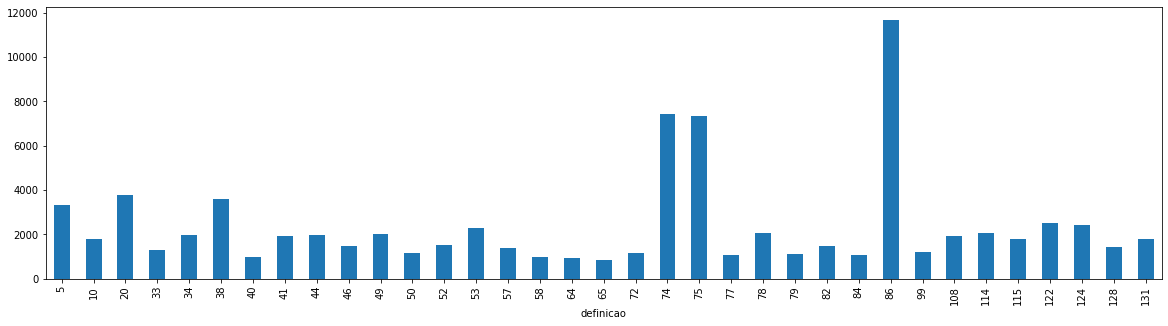

In [ ]:
fig = plt.figure(figsize=(20,5))
df.groupby('definicao').definicao.count().plot.bar(ylim=0)
fig.set_facecolor('xkcd:white')
plt.show()

## Filtra classes mais problemáticas

In [ ]:
df = df.loc[~df.definicao.isin(le.transform(['filtro de oleo', 'detergente 500ml', 'soro fisiologico 500ml',\
                                             'copo descartavel 150ml','leite em po integral 200g']).tolist())]

In [ ]:
classes = df['definicao'].unique().tolist()
class_to_descr = {i:descricoes[i] for i in sorted(classes)}
print(len(class_to_descr))
class_to_descr

31


{5: 'agua mineral 20lt',
 10: 'agua sanitaria 1lt',
 20: 'arroz 1kg',
 33: 'açucar cristal 1kg',
 34: 'açucar refinado 1kg',
 38: 'biscoito cream cracker',
 40: 'biscoito maizena 400g',
 41: 'biscoito maria 400g',
 44: 'botijao de gas de cozinha 13kg',
 46: 'cafe 250g',
 49: 'carne bovina',
 50: 'carne de charque',
 52: 'carne moida',
 53: 'cenoura',
 57: 'cimento 50kg',
 64: 'costela bovina',
 65: 'coxa e sobrecoxa de frango',
 74: 'diesel s-10',
 75: 'diesel s-500',
 77: 'farinha de mandioca 1kg',
 78: 'farinha de milho flocada 500g',
 79: 'farinha de trigo 1kg',
 84: 'frango inteiro',
 86: 'gasolina comum',
 108: 'macarrao espaguete 500g',
 114: 'margarina 500g',
 115: 'oleo de soja 900ml',
 122: 'peito de frango',
 124: 'polpa de fruta 1kg',
 128: 'refeição',
 131: 'sal refinado 1kg'}

## Dividindo em teste e treino

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['xprod'], df['definicao'], test_size=0.2, stratify=df['definicao'], random_state=0)

In [ ]:
'''
# pega os valores para teste que são menos repetidos, favorecendo treinamento com maior numero de amostras x['xprod'].value_counts()[  int(0.7*len(df['xprod'].value_counts())) ]   INCOMPLETO
df_test2 = df.groupby('definicao', group_keys=False).apply(lambda x: x.sample( int(0.3 * len( x['xprod'].unique() ) ) ))
df_test = df_test2.drop_duplicates(subset='xprod')
df_test_out = df_test2.iloc[~df_test2.index.isin(df_test.index.tolist())]

df = df[~df.xprod.isin(df_test.xprod)]

#balenceia classes
#class_size = int(df.groupby('definicao').definicao.count().median())
class_size = 700
classes = df['definicao'].unique().tolist()

df2 = df[0:0]
for classe in classes:
    df2 = df2.append(df[df.definicao== classe].sample(class_size,replace=True), ignore_index=True)

#df_index_out = df_original.iloc[~df_original.index.isin(df2.index.tolist())]
df_samples_out = df[~df.xprod.isin(df2.xprod)]
df = df2 

X_train, X_test, y_train, y_test = df['xprod'], df_test['xprod'], df['definicao'], df_test['definicao'] #X_train, X_test, y_train, y_test = train_test_split(df['xprod'], df['definicao'], test_size=0.2, random_state=0)
'''

"\n# pega os valores para teste que são menos repetidos, favorecendo treinamento com maior numero de amostras x['xprod'].value_counts()[  int(0.7*len(df['xprod'].value_counts())) ]   INCOMPLETO\ndf_test2 = df.groupby('definicao', group_keys=False).apply(lambda x: x.sample( int(0.3 * len( x['xprod'].unique() ) ) ))\ndf_test = df_test2.drop_duplicates(subset='xprod')\ndf_test_out = df_test2.iloc[~df_test2.index.isin(df_test.index.tolist())]\n\ndf = df[~df.xprod.isin(df_test.xprod)]\n\n#balenceia classes\n#class_size = int(df.groupby('definicao').definicao.count().median())\nclass_size = 700\nclasses = df['definicao'].unique().tolist()\n\ndf2 = df[0:0]\nfor classe in classes:\n    df2 = df2.append(df[df.definicao== classe].sample(class_size,replace=True), ignore_index=True)\n\n#df_index_out = df_original.iloc[~df_original.index.isin(df2.index.tolist())]\ndf_samples_out = df[~df.xprod.isin(df2.xprod)]\ndf = df2 \n\nX_train, X_test, y_train, y_test = df['xprod'], df_test['xprod'], df['defin

In [ ]:
'''
fig = plt.figure(figsize=(20,5))
df.groupby('definicao').definicao.count().plot.bar(ylim=0)
fig.set_facecolor('xkcd:white')
plt.show()
'''

"\nfig = plt.figure(figsize=(20,5))\ndf.groupby('definicao').definicao.count().plot.bar(ylim=0)\nfig.set_facecolor('xkcd:white')\nplt.show()\n"

In [ ]:
'''
fig = plt.figure(figsize=(20,5))
df_test.groupby('definicao').definicao.count().plot.bar(ylim=0)
fig.set_facecolor('xkcd:white')
plt.show()
'''

"\nfig = plt.figure(figsize=(20,5))\ndf_test.groupby('definicao').definicao.count().plot.bar(ylim=0)\nfig.set_facecolor('xkcd:white')\nplt.show()\n"

## Codificando xprod

In [ ]:
count_vect = CountVectorizer(ngram_range=(2,4),max_features=7000, min_df=2) #max_df=0.99
tfidf_transformer = TfidfTransformer()

X_train_counts = count_vect.fit_transform(X_train)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

X_test_counts_others = count_vect.transform(df_aux['xprod'])
X_test_tfidf_others = tfidf_transformer.transform(X_test_counts_others)

#X_test_counts_out = count_vect.transform(df_samples_out['xprod'])
#X_test_tfidf_out = tfidf_transformer.transform(X_test_counts_out)

### word2vec


In [ ]:
qtd_palavras = 15
qtd_dimensoes = 200
qtd_dimensoes_umap = 15 #mudar?

In [ ]:
'''sentences = [descr.split()[:qtd_palavras] for descr in df['xprod']]
sentences_teste = [descr.split()[:qtd_palavras] for descr in df_aux['xprod']]
vocab_sem_repetidos = [list(item) for item in set(tuple(row) for row in sentences+sentences_teste)]

model = Word2Vec(vocab_sem_repetidos,size=qtd_dimensoes, min_count=1, workers=-1)
doc_vectors = {}

for number, sent in enumerate(sentences):
    #agora dando peso maior pras primeiras palavras, peso decrescente ateh o final, numeros com mesmo peso da primeira palavra:
    if len(sent) == 0:
        doc_vectors[number] = np.zeros(qtd_dimensoes,)
    elif len(sent) == 1:
        doc_vectors[number] = model.wv[sent[0]]
    elif len(sent) > 1:
        pesos = np.array(range(len(sent))[::]) + 1
        pesos = 1 / pesos
        media = []
        divisao = 0
        counter = 0
        for word in sent:
            #### AGORA O MODEL EH W2V E O PESO EH DOBRADO PRA DIGITS:
            if word.isdigit():
                media.append(model.wv[word] * ((pesos[0]+pesos[-1])*(1/2)) )
                divisao += ((pesos[0]+pesos[-1])*(1/2))
            else:
                media.append(model.wv[word] * pesos[counter])
                divisao += pesos[counter]
            counter += 1
        doc_vectors[number] = np.array(media).sum(axis=0) / divisao #media de tudo
'''

"sentences = [descr.split()[:qtd_palavras] for descr in df['xprod']]\nsentences_teste = [descr.split()[:qtd_palavras] for descr in df_aux['xprod']]\nvocab_sem_repetidos = [list(item) for item in set(tuple(row) for row in sentences+sentences_teste)]\n\nmodel = Word2Vec(vocab_sem_repetidos,size=qtd_dimensoes, min_count=1, workers=-1)\ndoc_vectors = {}\n\nfor number, sent in enumerate(sentences):\n    #agora dando peso maior pras primeiras palavras, peso decrescente ateh o final, numeros com mesmo peso da primeira palavra:\n    if len(sent) == 0:\n        doc_vectors[number] = np.zeros(qtd_dimensoes,)\n    elif len(sent) == 1:\n        doc_vectors[number] = model.wv[sent[0]]\n    elif len(sent) > 1:\n        pesos = np.array(range(len(sent))[::]) + 1\n        pesos = 1 / pesos\n        media = []\n        divisao = 0\n        counter = 0\n        for word in sent:\n            #### AGORA O MODEL EH W2V E O PESO EH DOBRADO PRA DIGITS:\n            if word.isdigit():\n                media.

In [ ]:
#doc_vectors = pd.DataFrame(doc_vectors).T
#doc_vectors = doc_vectors.set_index(df.index) 

#scaler = StandardScaler()
#doc_vectors_std_df = pd.DataFrame(scaler.fit_transform(doc_vectors),index=doc_vectors.index,columns=doc_vectors.columns)

In [ ]:
'''
umap_redux = umap.UMAP(n_components=qtd_dimensoes_umap, random_state=999, metric='cosine')
umap_redux.fit(doc_vectors)
doc_vectors_std_df_umap = umap_redux.transform(X=doc_vectors)
'''
#umap_redux.fit(doc_vectors_std_df)
#doc_vectors_std_df_umap = umap_redux.transform(X=doc_vectors_std_df)


#df['avg_vec'] = pd.DataFrame(doc_vectors_std_df_umap).values.mean(axis=1)

"\numap_redux = umap.UMAP(n_components=qtd_dimensoes_umap, random_state=999, metric='cosine')\numap_redux.fit(doc_vectors)\ndoc_vectors_std_df_umap = umap_redux.transform(X=doc_vectors)\n"

In [ ]:
'''
sentences_teste = [descr.split()[:qtd_palavras] for descr in df_aux['xprod']]
doc_vectors_teste = {}
for number, sent in enumerate(sentences_teste):
    #agora dando peso maior pras primeiras palavras, peso decrescente ateh o final, numeros com mesmo peso da primeira palavra:
    if len(sent) == 0:
        doc_vectors_teste[number] = np.zeros(qtd_dimensoes,)
    elif len(sent) == 1:
        doc_vectors_teste[number] = model.wv[sent[0]]
    elif len(sent) > 1:
        pesos = np.array(range(len(sent))[::]) + 1
        pesos = 1 / pesos
        media = []
        divisao = 0
        counter = 0
        for word in sent:
            if word.isdigit():
                media.append(model.wv[word] * ((pesos[0]+pesos[-1])*(1/2)) )
                divisao += ((pesos[0]+pesos[-1])*(1/2))
            else:
                media.append(model.wv[word] * pesos[counter])
                divisao += pesos[counter]
            counter += 1
        doc_vectors_teste[number] = np.array(media).sum(axis=0) / divisao #media de tudo

doc_vectors_teste = pd.DataFrame(doc_vectors_teste).T
doc_vectors_teste = doc_vectors_teste.set_index(df_aux.index) 
#doc_vectors_std_df_teste = pd.DataFrame(scaler.fit_transform(doc_vectors_teste),index=doc_vectors_teste.index,columns=doc_vectors_teste.columns)
'''

"\nsentences_teste = [descr.split()[:qtd_palavras] for descr in df_aux['xprod']]\ndoc_vectors_teste = {}\nfor number, sent in enumerate(sentences_teste):\n    #agora dando peso maior pras primeiras palavras, peso decrescente ateh o final, numeros com mesmo peso da primeira palavra:\n    if len(sent) == 0:\n        doc_vectors_teste[number] = np.zeros(qtd_dimensoes,)\n    elif len(sent) == 1:\n        doc_vectors_teste[number] = model.wv[sent[0]]\n    elif len(sent) > 1:\n        pesos = np.array(range(len(sent))[::]) + 1\n        pesos = 1 / pesos\n        media = []\n        divisao = 0\n        counter = 0\n        for word in sent:\n            if word.isdigit():\n                media.append(model.wv[word] * ((pesos[0]+pesos[-1])*(1/2)) )\n                divisao += ((pesos[0]+pesos[-1])*(1/2))\n            else:\n                media.append(model.wv[word] * pesos[counter])\n                divisao += pesos[counter]\n            counter += 1\n        doc_vectors_teste[number] = np

In [ ]:
#umap_redux = umap.UMAP(n_components=qtd_dimensoes_umap, random_state=999, metric='cosine')
#umap_redux.fit(doc_vectors_std_df)

#doc_vectors_std_umap_teste = umap_redux.transform(X=pd.DataFrame(doc_vectors_teste))

### (over/under)sample

In [ ]:
#x_train, x_test, y_train, y_test = train_test_split(pd.DataFrame(doc_vectors_std_df_umap), df['definicao'], test_size=0.2, stratify=df['definicao'], random_state=0)

In [ ]:
#rus = RandomUnderSampler(replacement=False)
#x_train_over, y_train_over = rus.fit_sample(x_train, y_train)

rus = RandomOverSampler()
X_train_tfidf, y_train = rus.fit_sample(X_train_tfidf, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## Classificacao

### modelo

In [ ]:
if method == 'test':
    clf = abre(path_drive, f'{w2v[self.class_prod]}.pkl')
    y_pred = clf.predict(X_test_tfidf)
else:
    clf = MultinomialNB()

    kf = StratifiedKFold(n_splits=5, shuffle=True)
    kf.get_n_splits(X_train_tfidf)

    for train_index, test_index in kf.split(X_train_tfidf, y_train):
        X_train, _ = X_train_tfidf[train_index], X_train_tfidf[test_index]
        #Y_train, Y_test = y_train.iloc[train_index], y_train.iloc[test_index] p/ dataframe se n for usado rus
        Y_train, _ = y_train[train_index], y_train[test_index]
        clf = clf.fit(X_train, Y_train)

    y_pred = clf.predict(X_test_tfidf)
    print(f'Acurácia Teste: {accuracy_score(y_test, y_pred)}')

Acurácia Teste: 0.9562851442046073


### testes

In [ ]:
'''
clf = CalibratedClassifierCV(RandomForestClassifier())
clf.fit(x_train_over, y_train_over)

y_pred = clf.predict(x_test)
print(f'Acurácia Teste: {accuracy_score(y_test, y_pred)}')
__________________________________________________________________
X_train_tfidf = x_train_over

#clf = MultinomialNB()
kf = StratifiedKFold(n_splits=10, shuffle=True)
kf.get_n_splits(X_train_tfidf)
scores = []

for train_index, test_index in kf.split(x_train_over, y_train_over):
   X_train, X_test = X_train_tfidf[train_index], X_train_tfidf[test_index]
   #Y_train, Y_test = y_train.iloc[train_index], y_train.iloc[test_index] p/ dataframe se n for usado rus
   Y_train, Y_test = y_train_over[train_index], y_train_over[test_index]
   clf = clf.fit(X_train, Y_train)
   scores.append( accuracy_score(Y_test, clf.predict(X_test)) )

#print(f'Acurácia de Treinamento: {sum(scores) / len(scores)}')

y_pred = clf.predict(x_test)
print(f'Acurácia Teste: {accuracy_score(y_test, y_pred)}')
'''

"\nclf = CalibratedClassifierCV(RandomForestClassifier())\nclf.fit(x_train_over, y_train_over)\n\ny_pred = clf.predict(x_test)\nprint(f'Acurácia Teste: {accuracy_score(y_test, y_pred)}')\n__________________________________________________________________\nX_train_tfidf = x_train_over\n\n#clf = MultinomialNB()\nkf = StratifiedKFold(n_splits=10, shuffle=True)\nkf.get_n_splits(X_train_tfidf)\nscores = []\n\nfor train_index, test_index in kf.split(x_train_over, y_train_over):\n   X_train, X_test = X_train_tfidf[train_index], X_train_tfidf[test_index]\n   #Y_train, Y_test = y_train.iloc[train_index], y_train.iloc[test_index] p/ dataframe se n for usado rus\n   Y_train, Y_test = y_train_over[train_index], y_train_over[test_index]\n   clf = clf.fit(X_train, Y_train)\n   scores.append( accuracy_score(Y_test, clf.predict(X_test)) )\n\n#print(f'Acurácia de Treinamento: {sum(scores) / len(scores)}')\n\ny_pred = clf.predict(x_test)\nprint(f'Acurácia Teste: {accuracy_score(y_test, y_pred)}')\n"

In [ ]:
#clf.fit(X_train_tfidf, y_train)

#cv = StratifiedShuffleSplit(n_splits=5, test_size=.3, random_state=0)
#scores = cross_val_score(clf, X_test_tfidf, y_test, cv=cv)
#print('Acurácia cross-validation: %0.2f' % scores.mean())

#y_pred = clf.predict(X_test_tfidf)
#print(f'Acurácia: {accuracy_score(y_test, y_pred)}')

### Vendo a qualidade da classificação

"AUC is desirable for the following two reasons:

AUC is scale-invariant. It measures how well predictions are ranked, rather than their absolute values.
AUC is classification-threshold-invariant. It measures the quality of the model's predictions irrespective of what classification threshold is chosen.
However, both these reasons come with caveats, which may limit the usefulness of AUC in certain use cases:

Scale invariance is not always desirable. For example, sometimes we really do need well calibrated probability outputs, and AUC won’t tell us about that.

Classification-threshold invariance is not always desirable. In cases where there are wide disparities in the cost of false negatives vs. false positives, it may be critical to minimize one type of classification error. For example, when doing email spam detection, you likely want to prioritize minimizing false positives (even if that results in a significant increase of false negatives). AUC isn't a useful metric for this type of optimization."

In [ ]:
'''ytest = label_binarize(y_test, classes=sorted(classes))
print(roc_auc_score(ytest, clf.predict_proba(X_test_tfidf), multi_class='ovr'))
#print(classification_report(y_test, y_pred))
average_precision_score(ytest, clf.predict_proba(X_test_tfidf))'''

"ytest = label_binarize(y_test, classes=sorted(classes))\nprint(roc_auc_score(ytest, clf.predict_proba(X_test_tfidf), multi_class='ovr'))\n#print(classification_report(y_test, y_pred))\naverage_precision_score(ytest, clf.predict_proba(X_test_tfidf))"

Text(0.5, 1.0, 'Accuracy:0.956')

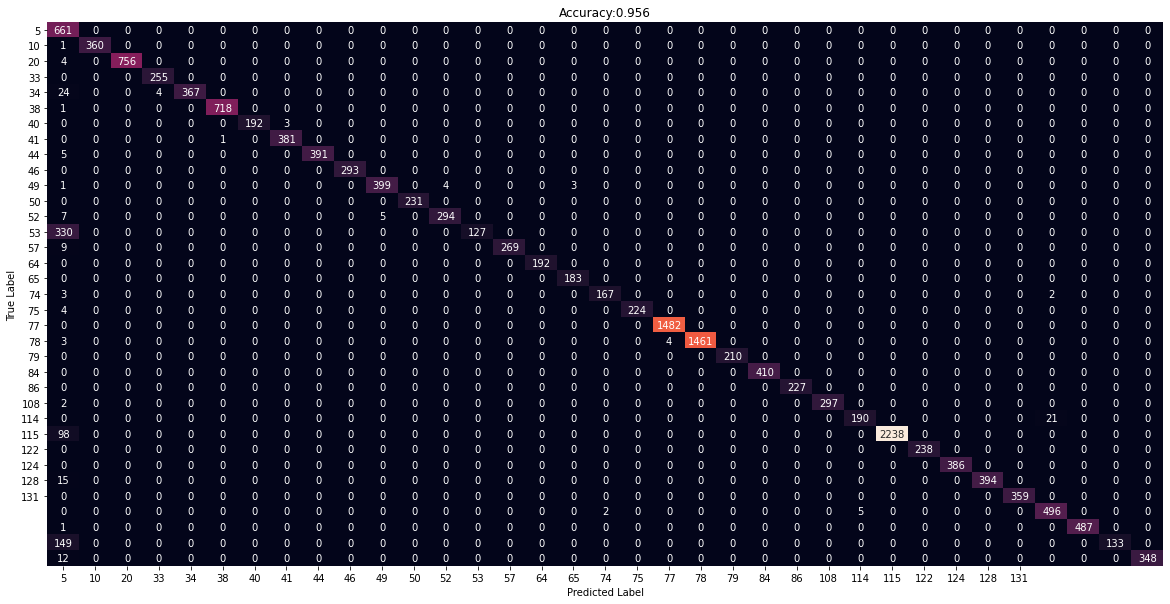

In [ ]:
#print(classification_report(y_test, y_pred))
plt.figure(figsize=(20,10))
cm = confusion_matrix(y_test, y_pred)
axes = sorted(classes)
sns.heatmap(cm, annot=True, cbar=False, fmt='g', xticklabels= axes, yticklabels=axes)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Accuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))

# Fazendo Predições

In [ ]:
# map index do valor predito com a classe real 
real_groups = sorted(set(y_train))
dictionary = dict(zip(list(range(len(real_groups))), real_groups))

### outros

In [ ]:
#y_prob = clf.predict_proba(doc_vectors_std_umap_teste)
y_prob = clf.predict_proba(X_test_tfidf_others)
y_pred_prob = [ dictionary[np.argmax(probs)] if max(probs) > 0.9 else None for probs in y_prob ]
df_aux['classe'] = y_pred_prob

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Novas amostras detectadas: 2385


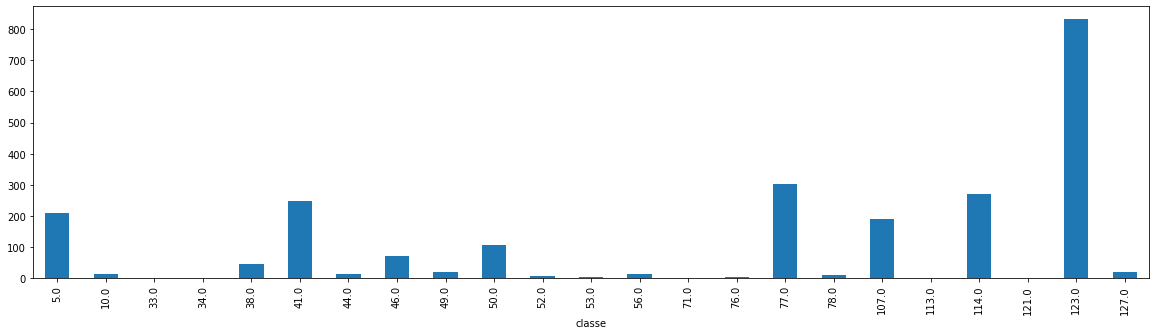

In [ ]:
qtd=df_aux[~df_aux['classe'].isna()]
print(f'Novas amostras detectadas: {len( qtd )}')

fig = plt.figure(figsize=(20,5))
df_aux.groupby('classe').classe.count().plot.bar(ylim=0)
fig.set_facecolor('xkcd:white')
plt.show()

In [ ]:
n = 10
testando = df_aux[df_aux['classe']==n]
print(len(testando))  
testando[:15][['Produto','xprod','ucom','ncm','vuncom']]

#df_original[df_original['definicao']==n][:30][['Produto','xprod','ucom']] 

15


,Produto,xprod,ucom,ncm,vuncom
204547,agua sanitaria tubrao 1lt,agu sanitarium tubra 1 lt,und,34022000,2.00
231788,agua sanitaria 2% 1lt c/ 12 und,agu sanitarium 2 1 lt d,cx,34022000,25.55
269455,agua sanitaria 2l,agu sanitarium 2 lt,und,34022000,1.95
290318,agua sanitaria 2% 1lt c/ 12 und,agu sanitarium 2 1 lt d,cx,34022000,25.55
315748,agua sanitaria brilux lavanda 1lt,agu sanitarium brilux lavand 1 lt,und,34022000,3.49
488841,agua sanitaria 2% 1lt c/ 12 und,agu sanitarium 2 1 lt d,cx,34022000,25.55
488870,agua sanitaria 2% 1lt c/ 12 und,agu sanitarium 2 1 lt d,cx,34022000,25.55
488970,agua sanitaria 2% 1lt c/ 12 und,agu sanitarium 2 1 lt d,cx,34022000,25.55
489126,agua sanitaria 2% 1lt c/ 12 und,agu sanitarium 2 1 lt d,cx,34022000,25.55
535471,agua sanitaria 5 litros,agu sanitarium 5 lt,und,40151900,7.30


In [ ]:
#df_aux[~df_aux['classe'].isna()].iloc[np.random.randint(len(df_aux[~df_aux['classe'].isna()]),size=15)][['Produto','classe']]

In [ ]:
'''
n1 = 53
n2 = 5
#df_aux[df_aux['xprod'].str.contains('oleo deisel')][:50]
lista_teste= df[df['definicao']==n1]['xprod'].unique().tolist() + df[df['definicao']==n2]['xprod'].unique().tolist()
vocab = [word for descr in lista_teste for word in descr.split()]
dict1 = [word for descr in df[df['definicao']==n1]['xprod'].unique().tolist() for word in descr.split()]
dict2 = [word for descr in df[df['definicao']==n2]['xprod'].unique().tolist() for word in descr.split()]
resu= [word for word in set(vocab) if word in dict2 and word in dict1]
resu'''

In [ ]:
#df[df['definicao']==53]['xprod'].unique().tolist()

### df_samples_out

In [ ]:
'''
y_prob = clf.predict_proba(X_test_tfidf_out)

y_pred_prob = [ dictionary[np.argmax(probs)] if max(probs) > 0.5 else None for probs in y_prob ]

df_samples_out['classe'] = y_pred_prob
'''
'''
fig = plt.figure(figsize=(20,5))
df_samples_out.groupby('classe').classe.count().plot.bar(ylim=0)
fig.set_facecolor('xkcd:white')
plt.show()
'''
'''
plt.figure(figsize=(20,10))
cm = confusion_matrix(df_samples_out[~df_samples_out['classe'].isnull()]['definicao'], df_samples_out[~df_samples_out['classe'].isnull()]['classe'].astype(int))
axes = sorted(df_samples_out[~df_samples_out['classe'].isnull()]['definicao'].unique())
sns.heatmap(cm, annot=True, cbar=False, fmt='g', xticklabels= axes, yticklabels=axes)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
'''

"\nplt.figure(figsize=(20,10))\ncm = confusion_matrix(df_samples_out[~df_samples_out['classe'].isnull()]['definicao'], df_samples_out[~df_samples_out['classe'].isnull()]['classe'].astype(int))\naxes = sorted(df_samples_out[~df_samples_out['classe'].isnull()]['definicao'].unique())\nsns.heatmap(cm, annot=True, cbar=False, fmt='g', xticklabels= axes, yticklabels=axes)\nplt.ylabel('True Label')\nplt.xlabel('Predicted Label')\n"

#Salva Resu

In [ ]:
'''
from google.colab import drive
drive.mount('/content/drive')
grava(clf, path_drive, 'multinomialNB_treinado.pkl')
'''

## absorve outros

In [ ]:
df_original['classe'] = df_original['definicao']
#df_aux = df_aux[~df_aux['classe'].isna()]
df_final = pd.concat([df_original, df_aux])

In [ ]:
fig = plt.figure(figsize=(20,5))
df_final.groupby('classe').definicao.count().plot.bar(ylim=0)
fig.set_facecolor('xkcd:white')
plt.show()

### outros save

#### ajeita ucom

In [ ]:
df_final.loc[(df_final.ncm.isin(['27101259', '27101921'])) &  
               (~df_final.definicao.isnull()), 'ucom']= 'lt'
df_final.loc[(df_final.ncm.isin(['27111910'])) &  
               (~df_final.definicao.isnull()), 'ucom']= 'kg'
df_final.loc[(df_final.ncm.isin(['02071400', '02071200', '02071300'])) &  
               (~df_final.ucom.isin(['cx'])) &
               (~df_final.definicao.isnull()), 'ucom']= 'kg'
df_final.loc[(df_final.ncm.isin(['02012090', '02013000','02022090', '02102000'])) &  
                (~df_final.definicao.isnull()), 'ucom']= 'kg' 
df_final.loc[(df_final.ncm.isin(['19053100', '19059020'])) &  
               (df_final.ucom.isin(['kg','pct'])) &
               (~df_final.definicao.isnull()), 'ucom']= 'und' 
df_final.loc[(df_final.ncm.isin(['19053100', '19059020'])) &  
               (df_final.ucom.isin(['frd'])) &
               (~df_final.definicao.isnull()), 'ucom']= 'cx' 
df_final.loc[(df_final.ncm.isin(['22011000'])) &  
               (~df_final.ucom.isin(['cx','frd'])) &
               (~df_final.definicao.isnull()), 'ucom']= 'und' 
df_final.loc[(df_final.ncm.isin(['22011000'])) &  
               (df_final.ucom.isin(['cx','frd'])) &
               (~df_final.definicao.isnull()), 'ucom']= 'pct'
df_final.loc[(df_final.ncm.isin(['96039000', '28289011', '34022000', '30049099'])) &  
               (~df_final.ucom.isin(['cx'])) &
               (~df_final.definicao.isnull()), 'ucom']= 'und'
df_final.loc[(df_final.ncm.isin(['39241000', '22011000'])) &  
               (df_final.ucom.isin(['und'])) &
               (~df_final.definicao.isnull()), 'ucom']= 'pct'
df_final.loc[(df_final.ncm.isin(['25010020', '34022000'])) &  
               (df_final.ucom.isin(['pct','kg'])) &
               (~df_final.definicao.isnull()), 'ucom']= 'und'
df_final.loc[(df_final.ncm.isin(['25232910','25223000','25221000','25222000'])) &  
               (df_final.ucom.isin(['kg','und','pct'])) &
               (~df_final.definicao.isnull()), 'ucom']= 'sc'
df_final.loc[(df_final.ncm.isin(['40151100','40151900'])) &  
               (df_final.ucom.isin(['pct'])) &
               (~df_final.definicao.isnull()), 'ucom']= 'und'
df_final.loc[(df_final.ncm.isin(['28289011','96039000','34022000'])) &  
               (df_final.ucom.isin(['frd','lt'])) &
               (~df_final.definicao.isnull()), 'ucom']= 'und'
df_final.loc[(df_final.ncm.isin(['28289011','96039000','34022000'])) &  
               (df_final.ucom.isin(['pct'])) &
               (~df_final.definicao.isnull()), 'ucom']= 'cx' 
df_final.loc[(df_final.ncm.isin(['17019900','02071400','34022000', '34022000', '15079011', '25232910'])) &  
               (df_final.ucom.isin(['frd','pct','kg'])) &
               (~df_final.definicao.isnull()), 'ucom']= 'und' 
df_final.loc[(df_final.ncm.isin(['17039000','17031000'])) &  
               (~df_final.ucom.isin(['und'])) &
               (~df_final.definicao.isnull()), 'ucom']= 'und' 
df_final.loc[(df_final.ncm.isin(['18069000','18061000'])) &  
               (~df_final.ucom.isin(['und'])) &
               (~df_final.definicao.isnull()), 'ucom']= 'und' 
df_final.loc[(df_final.ncm.isin(['30021229','30021590','30042029','30032029','30042099','30049099','30041019','30049037','30049059'])) &  
               (~df_final.definicao.isnull()), 'ucom']= 'und' 
df_final.loc[(df_final.ncm.isin(['30059090','30049099','30051090'])) &  
               (~df_final.ucom.isin(['pct'])) &
               (~df_final.definicao.isnull()), 'ucom']= 'und' 
df_final.loc[(df_final.ncm.isin(['30049024','30039071','30051090','30049069','30059090','30049099','30059019','30051010'])) &  
               (~df_final.definicao.isnull()), 'ucom']= 'und' 
df_final.loc[(df_final.ncm.isin(['36050000'])) &  
               (~df_final.ucom.isin(['und'])) &
               (~df_final.definicao.isnull()), 'ucom']= 'pct'  
df_final.loc[(df_final.ncm.isin(['84212300','84151011','21069090','39241000','28289011'])) &  
               (~df_final.ucom.isin(['und'])) &
               (~df_final.definicao.isnull()), 'ucom']= 'und'   
df_final.loc[(df_final.ncm.isin(['48181000','48189090','48183000'])) &  
               (~df_final.ucom.isin(['cx'])) &
               (~df_final.definicao.isnull()), 'ucom']= 'und' 
df_final.loc[(df_final.ncm.isin(['04022110'])) &  
               (df_final.ucom.isin(['cx','lt','kg'])) &
               (~df_final.definicao.isnull()), 'ucom']= 'und'   
df_final.loc[(df_final.ncm.isin(['04031000','04039000'])) &  
               (df_final.ucom.isin(['lt','pct'])) &
               (~df_final.definicao.isnull()), 'ucom']= 'und' 
df_final.loc[(df_final.ncm.isin(['20060000', '07020000', '07061000'])) &  
               (~df_final.ucom.isin(['kg'])) &
               (~df_final.definicao.isnull()), 'ucom']= 'kg'  
df_final.loc[(df_final.ncm.isin(['20089900','20083000','20099000','20060000'])) &  
               (df_final.ucom.isin(['kg','pct'])) &
               (~df_final.definicao.isnull()), 'ucom']= 'und'   
df_final.loc[(df_final.ncm.isin(['09012100'])) &  
               (df_final.ucom.isin(['kg','pct'])) &
               (~df_final.definicao.isnull()), 'ucom']= 'und'   
df_final.loc[(df_final.ncm.isin(['09012100'])) &  
               (df_final.ucom.isin(['cx'])) &
               (~df_final.definicao.isnull()), 'ucom']= 'frd' 
df_final.loc[(df_final.ncm.isin(['15171000','15079011','15091000'])) &  
               (~df_final.ucom.isin(['cx'])) &
               (~df_final.definicao.isnull()), 'ucom']= 'und' 
df_final.loc[(df_final.ncm.isin(['11041900','11022000','11042300','11062000','11081400', '11022000','11010010'])) &  
               (~df_final.ucom.isin(['frd'])) &
               (~df_final.definicao.isnull()), 'ucom']= 'und' 
df_final.loc[(df_final.ncm.isin(['11041200','11081200'])) &  
               (~df_final.ucom.isin(['und'])) &
               (~df_final.definicao.isnull()), 'ucom']= 'und' 
df_final.loc[(~df_final.definicao.isnull()) &  
               (~df_final.ucom.isin(['cx','pct','frd'])) &
               (df_final.definicao.str.contains('c (\d+(\.|,)\d+) (un|und|unida)|(\d+(\.|,)\d+) (un|und|unida)',regex=True)), 'ucom']= 'cx'
df_final.loc[(~df_final.definicao.isnull()) &  
               (~df_final.ucom.isin(['cx','frd','pct'])) &
               (df_final.definicao.str.contains('(frd|fd) c ((\d+(\.|,)\d+)|\d+) (kg|un|und|unida)|(frd|fd) (\d+(\.|,)\d+) (un|und|unida)',regex=True)), 'ucom']= 'frd'

#### save

In [ ]:
'''df = df_produto[~df_produto['definicao'].isin(['outros'])] 

le = LabelEncoder()
df['classe'] = le.transform(df.definicao)
descricoes = le.classes_
grupos = le.transform(le.classes_)
'''

In [ ]:
calc_preco(df_final, grupos, descricoes)
df_final = df_final.round(2)
df_final['qcom'] = df_final['qcom'].astype(int)
df_final['vuncom'] = df_final['vuncom'].astype(str).str.replace('.',",")  
df_final['vprod'] = df_final['vprod'].astype(str).str.replace('.',",")
df_final = reindex_grupos(df_final)
df_final.to_csv('produtos_classificados.csv', encoding="utf-8-sig")

In [ ]:
'''
#mesclando classes preditas com determinadas
df_teste = pd.DataFrame(y_test)
df_train = pd.DataFrame(y_train)
#y_pred n preserva index, tem q pegar do teste (sobrescreve teste)
df_teste['definicao'] = y_pred.tolist()

df['classe'] = pd.concat([df_teste, df_train])

#df_out['classe'] = df_out['definicao']
#df = pd.concat([df, df_out])
'''

## unused

In [ ]:
'''
df_produto['classe'] = np.nan
for i, row in df_produto.iterrows():
      if not df[df['Produto'] == row['Produto']].empty:
        df_produto.loc[i,'classe'] = df[df['Produto'] == row['Produto']]['classe'].iloc[0]
'''

In [ ]:
'''
df_teste2['classe'] = y_pred2.tolist()
for i, row in df_produto.iterrows():
  if pd.isna(row['classe']):
    df_produto.loc[i,'classe'] = df_teste2.loc[i,'classe']
'''